In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from scipy import stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, plot_roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz

import pickle

import requests
from bs4 import BeautifulSoup as bs
from bs4 import Comment

import regex
import datetime

from tqdm import tqdm

# Data Uploading & Cleaning

## Odds Data-Downloaded from Website

Due to the unusual and shortened schedule in 2020, chose to drop.  Similarly for the not-yet-completed 2021 season.

In [ ]:
years=['2019','2018','2017','2016','2015']
data={}

In [ ]:
for yr in years:
    data[yr]=pd.read_excel('../Raw Data/'+yr+'.xlsx')

In [ ]:
for yr,df in data.items():
    df_clean=df.drop(['Rot','1st','2nd','3rd','4th','5th','6th','7th','8th','9th','Open','Close','RunLine','Run Line','Unnamed: 18'],axis=1,errors='ignore')
    df_clean['year']=int(yr)
    df_clean['day']=df_clean.Date.apply(lambda x:x%100)
    df_clean['month']=df_clean.Date.apply(lambda x:int(np.round(x,-2)/100))
    df_clean['date']=df_clean.apply(lambda r:datetime.datetime(r.year,r.month,r.day),axis=1)
    df_clean.drop(['Date','day'],axis=1,inplace=True)
    data[yr]=df_clean.rename({'Open OU':'OpenOU','Close OU':'CloseOU','Unnamed: 20':'Open_Odds','Unnamed: 22':'Close_Odds'},axis=1)

In [ ]:
all_data=pd.concat(data.values(),ignore_index=True)

In [ ]:
patt=r'\-[A-Z]{1}'
all_data.Pitcher=all_data.Pitcher.str.replace(patt,'')

Checking team labels in the odds data, note a couple of issues to fix.

In [ ]:
all_data.Team.value_counts()

First, some inconsistencent labeling (LOS v LA, e.g.).

In [ ]:
all_data.Team.replace({'CUB':'CHC','LOS':'LAD','SFG':'SFO','BRS':'BOS'}).value_counts()

In [ ]:
all_data.Team=all_data.Team.replace({'CUB':'CHC','LOS':'LAD','SFG':'SFO','BRS':'BOS'})

Second, need to adjust labels to be consistent with official labels.  

In [ ]:
all_data.Team=all_data.Team.replace({
                                    'KAN':'KCR',
                                    'TAM':'TBR',
                                    'SDG':'SDP',
                                    'WAS':'WSN',
                                    'SFO':'SFG',
                                    'CWS':'CHW'
                                    })

In [ ]:
all_data

Next, looking at Home/Away labels, there are four (two games) rows which have neither.  Upon further expection, this comes from games played outside of the US.  Links:

1) https://www.baseball-reference.com/boxes/OAK/OAK201903200.shtml

2) https://www.baseball-reference.com/boxes/OAK/OAK201903210.shtml

In [ ]:
all_data.VH.value_counts()

In [ ]:
all_data[all_data.VH=='N']

In [ ]:
all_data.at[0,'VH']='V'
all_data.at[1,'VH']='H'
all_data.at[2,'VH']='V'
all_data.at[3,'VH']='H'

In [ ]:
all_data.head()

In [ ]:
all_data.VH.value_counts()

Next, need to clean up a single observation with missing run data.  Link:

https://www.baseball-reference.com/boxes/PIT/PIT201606071.shtml

Convert column into integers.

In [ ]:
all_data.Final.value_counts()

In [ ]:
all_data[all_data.Final=='NL']

In [ ]:
all_data.at[16276,'Final']=3
all_data.at[16277,'Final']=3

In [ ]:
all_data.Final.value_counts()

In [ ]:
all_data.Final=all_data.Final.astype(int)

Next looking @ the target variable, there are some outrageous values that cannot be explained.  Since there is no other resource to check for the correct value, replace the line @ close with the line @ open.

Finally, convert the column into float.

In [ ]:
all_data.CloseOU.value_counts()

In [ ]:
all_data[all_data.CloseOU > 20]

In [ ]:
all_data.CloseOU=all_data.apply(lambda r:r.OpenOU if r.CloseOU>20 else r.CloseOU,axis=1)

In [ ]:
all_data.CloseOU.value_counts()

In [ ]:
all_data.CloseOU=all_data.CloseOU.astype(float)

The original data is a bit confusing.  For each game, there are two rows in the dataset: one containing data for the Road team and one for the Home Team.  However, the over-under variable in both rows refers to the total runs scored.  

As a result, need to consolidate each row-pair into a single row with both Home and Away data.  Because the paired rows are adjacent, it is easy to combine.  This was done for each row--even though it adds significant execution time--and removed duplicates to be safe.

In [ ]:
all_data['Home_Pitcher']=''
all_data['Away_Pitcher']=''
all_data['Home_Team']=''
all_data['Away_Team']=''
all_data['Home_Score']=0
all_data['Away_Score']=0
for i,row in all_data.iterrows():
    if row.VH=='V':
        all_data.loc[i,'Away_Pitcher']=all_data.loc[i,'Pitcher']
        all_data.loc[i,'Away_Team']=all_data.loc[i,'Team']
        all_data.loc[i,'Away_Score']=all_data.loc[i,'Final']
        all_data.loc[i,'Home_Score']=all_data.loc[i+1,'Final']
        all_data.loc[i,'Home_Team']=all_data.loc[i+1,'Team']
        all_data.loc[i,'Home_Pitcher']=all_data.loc[i+1,'Pitcher']
        pass
    elif row.VH=='H':
        all_data.loc[i,'Away_Pitcher']=all_data.loc[i-1,'Pitcher']
        all_data.loc[i,'Away_Team']=all_data.loc[i-1,'Team']
        all_data.loc[i,'Away_Score']=all_data.loc[i-1,'Final']
        all_data.loc[i,'Home_Score']=all_data.loc[i,'Final']
        all_data.loc[i,'Home_Team']=all_data.loc[i,'Team']
        all_data.loc[i,'Home_Pitcher']=all_data.loc[i,'Pitcher']
        pass
    else:
        pass
all_data

In [ ]:
all_data=all_data.drop_duplicates(subset=['Away_Pitcher','Home_Pitcher','date'],ignore_index=True)
all_data

At this point, it makes sense to start dropping some unneeded rows.

In [ ]:
all_data.drop(['VH','Team','Pitcher','Final','OpenOU','Open_Odds'],axis=1,inplace=True)
all_data

Finally, create some additional features:  Total Runs; OVER Dummy Variable; and a key value.

To build the key value, start with date + Home Team (later date sources will use a similar key).  However, because of double-headers, this does not create unique key values.  Next, tried date combined with the runs scored by the home and away team.  This works well with one exception where both games in a double header ended in the same score.  These observations' key-values were manually adjusted.

In [ ]:
all_data['Total_Runs']=all_data['Home_Score']+all_data['Away_Score']
all_data['OVER']=all_data.apply(lambda r:r.Total_Runs>r.CloseOU,axis=1)
all_data

In [ ]:
all_data['KEY']=all_data.date.apply(lambda d:str(d).replace(' 00:00:00','-'))+all_data.Home_Team

In [ ]:
all_data[all_data.KEY.duplicated(keep=False)]

In [ ]:
all_data.KEY=all_data.apply(lambda r:r.KEY+str(r.Home_Score)+str(r.Away_Score),axis=1)
all_data[all_data.KEY.duplicated(keep=False)]

In [ ]:
all_data.at[8147,'KEY']=all_data.at[8147,'KEY']='A'
all_data.at[8162,'KEY']=all_data.at[8162,'KEY']='B'

In [ ]:
all_data

In [ ]:
all_data.to_pickle('../Base DFs/Odds_Data.pkl')

## Matchup & Other Game Info Scrapped from Baseball-Reference

In [2]:
TEAMS={}
with open('../Teams.txt') as f:
    for r in f.readlines():
        t=r.split(',')
        TEAMS[t[0]]=t[1]

YRs=['2019','2018','2017','2016','2015']
odds_data=pd.read_pickle('../Base DFs/Odds_Data.pkl')

Baseball-Reference has a page with the entire MLB schedule in any given year.  From this, collect links to the game's box score and the team's homepage along with the score and date (use to tie to the Odds Data from above).

In [3]:
s_patt=r'([A-Za-z .\']+) \(([0-9]{1,2})\)\s{0,2}\@ ([A-Za-z .\']+) \(([0-9]{1,2})\)'
s_rgx=regex.compile(s_patt)
d_patt=r'[A-Z]{3}([0-9]{8})[0-9]{1}\.shtml'
d_rgx=regex.compile(d_patt)

In [4]:
game_data=[]
for yr in YRs:
    link='https://www.baseball-reference.com/leagues/MLB/'+yr+'-schedule.shtml'
    r=requests.get(link)
    soup=bs(r.content)
    table=soup.find('span',attrs={'data-label':'MLB Schedule'}).parent.find_next_sibling('div')
    games=table.find_all('p',attrs={'class':'game'})
    for g in tqdm(games):
        s=' '.join(g.stripped_strings)
        info=s_rgx.search(s).groups()
        links=g.find_all('a')
        l=links[-1]['href']
        d={'Away_Team':links[0]['href'],
           'Home_Team':links[1]['href'],
           'Away_Score':info[1],
           'Home_Score':info[3],
           'link':l,
           'date':pd.to_datetime(d_rgx.search(l).groups()[0],format='%Y%m%d')
          }
        game_data.append(d)

100%|██████████| 2429/2429 [00:00<00:00, 6531.42it/s]


In [5]:
len(game_data)

12147

In [6]:
games_meta=pd.DataFrame(game_data)
games_meta

,Away_Team,Home_Team,Away_Score,Home_Score,link,date
0,/teams/SEA/2019.shtml,/teams/OAK/2019.shtml,9,7,/boxes/OAK/OAK201903200.shtml,2019-03-20
1,/teams/SEA/2019.shtml,/teams/OAK/2019.shtml,5,4,/boxes/OAK/OAK201903210.shtml,2019-03-21
2,/teams/PIT/2019.shtml,/teams/CIN/2019.shtml,3,5,/boxes/CIN/CIN201903280.shtml,2019-03-28
3,/teams/CHW/2019.shtml,/teams/KCR/2019.shtml,3,5,/boxes/KCA/KCA201903280.shtml,2019-03-28
4,/teams/ARI/2019.shtml,/teams/LAD/2019.shtml,5,12,/boxes/LAN/LAN201903280.shtml,2019-03-28
...,...,...,...,...,...,...
12142,/teams/CIN/2015.shtml,/teams/PIT/2015.shtml,0,4,/boxes/PIT/PIT201510040.shtml,2015-10-04
12143,/teams/OAK/2015.shtml,/teams/SEA/2015.shtml,2,3,/boxes/SEA/SEA201510040.shtml,2015-10-04
12144,/teams/COL/2015.shtml,/teams/SFG/2015.shtml,7,3,/boxes/SFN/SFN201510040.shtml,2015-10-04
12145,/teams/TOR/2015.shtml,/teams/TBR/2015.shtml,3,12,/boxes/TBA/TBA201510040.shtml,2015-10-04


In [7]:
patt=r'\/teams\/([A-Z]{3})\/[0-9]{4}\.shtml'
games_meta.Away_Team=games_meta.Away_Team.str.extract(patt)
games_meta.Home_Team=games_meta.Home_Team.str.extract(patt)
games_meta

,Away_Team,Home_Team,Away_Score,Home_Score,link,date
0,SEA,OAK,9,7,/boxes/OAK/OAK201903200.shtml,2019-03-20
1,SEA,OAK,5,4,/boxes/OAK/OAK201903210.shtml,2019-03-21
2,PIT,CIN,3,5,/boxes/CIN/CIN201903280.shtml,2019-03-28
3,CHW,KCR,3,5,/boxes/KCA/KCA201903280.shtml,2019-03-28
4,ARI,LAD,5,12,/boxes/LAN/LAN201903280.shtml,2019-03-28
...,...,...,...,...,...,...
12142,CIN,PIT,0,4,/boxes/PIT/PIT201510040.shtml,2015-10-04
12143,OAK,SEA,2,3,/boxes/SEA/SEA201510040.shtml,2015-10-04
12144,COL,SFG,7,3,/boxes/SFN/SFN201510040.shtml,2015-10-04
12145,TOR,TBR,3,12,/boxes/TBA/TBA201510040.shtml,2015-10-04


In [8]:
games_meta['KEY']=games_meta.date.apply(lambda d:str(d).replace(' 00:00:00','-'))+games_meta.Home_Team
sum(games_meta.KEY.duplicated(keep=False))

278

In [9]:
games_meta.KEY=games_meta.apply(lambda r:r.KEY+str(r.Home_Score)+str(r.Away_Score),axis=1)
games_meta[games_meta.KEY.duplicated(keep=False)]

,Away_Team,Home_Team,Away_Score,Home_Score,link,date,KEY
8158,NYM,PIT,1,3,/boxes/PIT/PIT201606071.shtml,2016-06-07,2016-06-07-PIT31
8159,NYM,PIT,1,3,/boxes/PIT/PIT201606072.shtml,2016-06-07,2016-06-07-PIT31


In [10]:
games_meta.at[8158,'KEY']=games_meta.at[8158,'KEY']='A'
games_meta.at[8159,'KEY']=games_meta.at[8159,'KEY']='B'

In [11]:
games_meta

,Away_Team,Home_Team,Away_Score,Home_Score,link,date,KEY
0,SEA,OAK,9,7,/boxes/OAK/OAK201903200.shtml,2019-03-20,2019-03-20-OAK79
1,SEA,OAK,5,4,/boxes/OAK/OAK201903210.shtml,2019-03-21,2019-03-21-OAK45
2,PIT,CIN,3,5,/boxes/CIN/CIN201903280.shtml,2019-03-28,2019-03-28-CIN53
3,CHW,KCR,3,5,/boxes/KCA/KCA201903280.shtml,2019-03-28,2019-03-28-KCR53
4,ARI,LAD,5,12,/boxes/LAN/LAN201903280.shtml,2019-03-28,2019-03-28-LAD125
...,...,...,...,...,...,...,...
12142,CIN,PIT,0,4,/boxes/PIT/PIT201510040.shtml,2015-10-04,2015-10-04-PIT40
12143,OAK,SEA,2,3,/boxes/SEA/SEA201510040.shtml,2015-10-04,2015-10-04-SEA32
12144,COL,SFG,7,3,/boxes/SFN/SFN201510040.shtml,2015-10-04,2015-10-04-SFG37
12145,TOR,TBR,3,12,/boxes/TBA/TBA201510040.shtml,2015-10-04,2015-10-04-TBR123


In [12]:
games_meta.to_pickle('../Base DFs/Games_Meta.pkl')

On merge, note the loss of data. This is because the score reported in the odds data does not match what was collected from Baseball-Reference.  Given the size of the dataset, it makes sense to drop these observations (31 in total.)

In [13]:
X=pd.merge(games_meta,odds_data,on='KEY',how='outer')
X.dropna(subset=['Away_Team_x','Away_Team_y'])

,Away_Team_x,Home_Team_x,Away_Score_x,Home_Score_x,link,date_x,KEY,CloseOU,Close_Odds,year,month,date_y,Home_Pitcher,Away_Pitcher,Home_Team_y,Away_Team_y,Home_Score_y,Away_Score_y,Total_Runs,OVER
0,SEA,OAK,9,7,/boxes/OAK/OAK201903200.shtml,2019-03-20,2019-03-20-OAK79,8.5,-120.0,2019.0,3.0,2019-03-20,MFIERS,MGONZALES,OAK,SEA,7.0,9.0,16.0,True
1,SEA,OAK,5,4,/boxes/OAK/OAK201903210.shtml,2019-03-21,2019-03-21-OAK45,9.0,-130.0,2019.0,3.0,2019-03-21,MESTRADA,YKIKUCHI,OAK,SEA,4.0,5.0,9.0,False
2,PIT,CIN,3,5,/boxes/CIN/CIN201903280.shtml,2019-03-28,2019-03-28-CIN53,8.5,-105.0,2019.0,3.0,2019-03-28,LCASTILLO,JTAILLON,CIN,PIT,5.0,3.0,8.0,False
3,CHW,KCR,3,5,/boxes/KCA/KCA201903280.shtml,2019-03-28,2019-03-28-KCR53,8.5,-105.0,2019.0,3.0,2019-03-28,BKELLER,CRODON,KCR,CHW,5.0,3.0,8.0,False
4,ARI,LAD,5,12,/boxes/LAN/LAN201903280.shtml,2019-03-28,2019-03-28-LAD125,7.0,-120.0,2019.0,3.0,2019-03-28,HRYU,ZGREINKE,LAD,ARI,12.0,5.0,17.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12142,CIN,PIT,0,4,/boxes/PIT/PIT201510040.shtml,2015-10-04,2015-10-04-PIT40,7.5,-105.0,2015.0,10.0,2015-10-04,JHAPP,JSMITH,PIT,CIN,4.0,0.0,4.0,False
12143,OAK,SEA,2,3,/boxes/SEA/SEA201510040.shtml,2015-10-04,2015-10-04-SEA32,7.5,-115.0,2015.0,10.0,2015-10-04,VNUNO,CBASSITT,SEA,OAK,3.0,2.0,5.0,False
12144,COL,SFG,7,3,/boxes/SFN/SFN201510040.shtml,2015-10-04,2015-10-04-SFG37,7.5,-115.0,2015.0,10.0,2015-10-04,MCAIN,CBERGMAN,SFG,COL,3.0,7.0,10.0,True
12145,TOR,TBR,3,12,/boxes/TBA/TBA201510040.shtml,2015-10-04,2015-10-04-TBR123,8.5,-120.0,2015.0,10.0,2015-10-04,MMOORE,MBUEHRLE,TBR,TOR,12.0,3.0,15.0,True


In [14]:
game_data=pd.merge(games_meta,odds_data,on='KEY',how='inner')
game_data=game_data.drop(['Away_Score_y','Home_Score_y','Away_Team_y','Home_Team_y','Total_Runs','date_y'],axis=1)
game_data=game_data.rename({'Away_Score_x':'Away_Score','Home_Score_x':'Home_Score','Away_Team_x':'Away_Team','Home_Team_x':'Home_Team','date_x':'date'},axis=1)
game_data=game_data.astype({'Away_Score':'int64','Home_Score':'int64','Close_Odds':'int64','month':'int64','year':'int64'})
game_data.CloseOU=game_data.CloseOU.astype(float)
game_data['Total_Runs']=game_data.Away_Score+game_data.Home_Score
game_data

,Away_Team,Home_Team,Away_Score,Home_Score,link,date,KEY,CloseOU,Close_Odds,year,month,Home_Pitcher,Away_Pitcher,OVER,Total_Runs
0,SEA,OAK,9,7,/boxes/OAK/OAK201903200.shtml,2019-03-20,2019-03-20-OAK79,8.5,-120,2019,3,MFIERS,MGONZALES,True,16
1,SEA,OAK,5,4,/boxes/OAK/OAK201903210.shtml,2019-03-21,2019-03-21-OAK45,9.0,-130,2019,3,MESTRADA,YKIKUCHI,False,9
2,PIT,CIN,3,5,/boxes/CIN/CIN201903280.shtml,2019-03-28,2019-03-28-CIN53,8.5,-105,2019,3,LCASTILLO,JTAILLON,False,8
3,CHW,KCR,3,5,/boxes/KCA/KCA201903280.shtml,2019-03-28,2019-03-28-KCR53,8.5,-105,2019,3,BKELLER,CRODON,False,8
4,ARI,LAD,5,12,/boxes/LAN/LAN201903280.shtml,2019-03-28,2019-03-28-LAD125,7.0,-120,2019,3,HRYU,ZGREINKE,True,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12111,CIN,PIT,0,4,/boxes/PIT/PIT201510040.shtml,2015-10-04,2015-10-04-PIT40,7.5,-105,2015,10,JHAPP,JSMITH,False,4
12112,OAK,SEA,2,3,/boxes/SEA/SEA201510040.shtml,2015-10-04,2015-10-04-SEA32,7.5,-115,2015,10,VNUNO,CBASSITT,False,5
12113,COL,SFG,7,3,/boxes/SFN/SFN201510040.shtml,2015-10-04,2015-10-04-SFG37,7.5,-115,2015,10,MCAIN,CBERGMAN,True,10
12114,TOR,TBR,3,12,/boxes/TBA/TBA201510040.shtml,2015-10-04,2015-10-04-TBR123,8.5,-120,2015,10,MMOORE,MBUEHRLE,True,15


Collect some additional information on each game from Baseball-Reference and merge with the other two dataframes.

In [15]:
base='https://www.baseball-reference.com/teams/{t}/{y}-schedule-scores.shtml'
stats=['boxscore','day_or_night','attendance','cli']
game_stats={}

In [16]:
for yr in YRs:
    for team in TEAMS.keys():
        link=base.format_map({'t':team,'y':yr})
        r=requests.get(link)
        soup=bs(r.content)
        table=soup.find('table',attrs={'id':'team_schedule'}).tbody
        games=table.find_all('tr')
        i=1
        for g in games:
            info=g.find_all('td',attrs={'data-stat':stats})
            if(info):
                link=info[0].a['href']
                d=dict(zip(stats[1:],[col.text for col in info[1:]]))
                d['link']=link
                game_stats[team+'_'+yr+'_'+str(i)]=d
                i+=1

In [17]:
game_logs=pd.DataFrame.from_dict(game_stats,orient='index')
#game_logs.attendance=game_logs.attendance.astype(int)
#game_logs.cli=game_logs.cli.astype(float)
game_logs.to_pickle('../Base DFs/Games_Info_I.pkl')
game_logs

,day_or_night,attendance,cli,link
ARI_2019_1,D,"53,086",1.08,/boxes/LAN/LAN201903280.shtml
ARI_2019_2,N,"42,266",.99,/boxes/LAN/LAN201903290.shtml
ARI_2019_3,N,"50,626",1.06,/boxes/LAN/LAN201903300.shtml
ARI_2019_4,D,"43,815",1.04,/boxes/LAN/LAN201903310.shtml
ARI_2019_5,N,"18,683",.98,/boxes/SDN/SDN201904010.shtml
...,...,...,...,...
WSN_2015_158,N,"13,860",.00,/boxes/ATL/ATL201509300.shtml
WSN_2015_159,N,"37,790",.00,/boxes/ATL/ATL201510010.shtml
WSN_2015_160,D,"39,465",.00,/boxes/NYN/NYN201510031.shtml
WSN_2015_161,N,"41,480",.00,/boxes/NYN/NYN201510032.shtml


In [18]:
game_data=pd.merge(game_data,game_logs.drop_duplicates(['link']),left_on=['link'],right_on=['link'])
game_data

,Away_Team,Home_Team,Away_Score,Home_Score,link,date,KEY,CloseOU,Close_Odds,year,month,Home_Pitcher,Away_Pitcher,OVER,Total_Runs,day_or_night,attendance,cli
0,SEA,OAK,9,7,/boxes/OAK/OAK201903200.shtml,2019-03-20,2019-03-20-OAK79,8.5,-120,2019,3,MFIERS,MGONZALES,True,16,N,"45,787",1.10
1,SEA,OAK,5,4,/boxes/OAK/OAK201903210.shtml,2019-03-21,2019-03-21-OAK45,9.0,-130,2019,3,MESTRADA,YKIKUCHI,False,9,N,"46,451",1.01
2,PIT,CIN,3,5,/boxes/CIN/CIN201903280.shtml,2019-03-28,2019-03-28-CIN53,8.5,-105,2019,3,LCASTILLO,JTAILLON,False,8,D,"44,049",1.06
3,CHW,KCR,3,5,/boxes/KCA/KCA201903280.shtml,2019-03-28,2019-03-28-KCR53,8.5,-105,2019,3,BKELLER,CRODON,False,8,N,"31,675",1.08
4,ARI,LAD,5,12,/boxes/LAN/LAN201903280.shtml,2019-03-28,2019-03-28-LAD125,7.0,-120,2019,3,HRYU,ZGREINKE,True,17,D,"53,086",1.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12111,CIN,PIT,0,4,/boxes/PIT/PIT201510040.shtml,2015-10-04,2015-10-04-PIT40,7.5,-105,2015,10,JHAPP,JSMITH,False,4,D,"35,362",.00
12112,OAK,SEA,2,3,/boxes/SEA/SEA201510040.shtml,2015-10-04,2015-10-04-SEA32,7.5,-115,2015,10,VNUNO,CBASSITT,False,5,D,"22,402",.00
12113,COL,SFG,7,3,/boxes/SFN/SFN201510040.shtml,2015-10-04,2015-10-04-SFG37,7.5,-115,2015,10,MCAIN,CBERGMAN,True,10,D,"41,399",.00
12114,TOR,TBR,3,12,/boxes/TBA/TBA201510040.shtml,2015-10-04,2015-10-04-TBR123,8.5,-120,2015,10,MMOORE,MBUEHRLE,True,15,D,"15,815",.00


The pitching matchup in the odds data is not reliably formatted (sometimes first initial and full last name; just last name; and partial last name.  Refer to Baseball-Reference's box score page to collect the name and link to both pitchers' player's page.  The boxscore link is then used to merge the resulting dataframe with the other dataframes.

In [19]:
base='https://www.baseball-reference.com'
more_data={}
#checked=[]

for game in tqdm(game_data.link):
    #if(game in checked):
    #    pass
    #else:
    #    checked.append(game)
    try:
        D={}
        link=base+game
        r=requests.get(link)
        soup=bs(r.content)
        X=soup.find('span',attrs={'data-label':'Pitching Lines and Info'}).parent.parent
        lineups=bs(X.find_all(text=lambda text:isinstance(text,Comment))[0]).find_all('table')
        pitcher=lineups[0].tbody.tr.th.a
        D['Away_Pitch']=(pitcher.text,pitcher['href'])
        pitcher=lineups[1].tbody.tr.th.a
        D['Home_Pitch']=(pitcher.text,pitcher['href'])
        X=soup.find('span',attrs={'data-label':'Other Info'}).parent.parent
        other=bs(X.find_all(text=lambda text:isinstance(text,Comment))[0])
        D['other']=other.text.strip()
        more_data[game]=D
    except:
        print(game)
        pass

100%|██████████| 12116/12116 [43:12<00:00,  4.67it/s] 


In [20]:
game_detail=pd.DataFrame.from_dict(more_data,orient='index')
game_detail

,Away_Pitch,Home_Pitch,other
/boxes/OAK/OAK201903200.shtml,"(Marco Gonzales, /players/g/gonzama02.shtml)","(Mike Fiers, /players/f/fiersmi01.shtml)","Umpires: HP - Jeff Nelson, 1B - Tripp Gibson, ..."
/boxes/OAK/OAK201903210.shtml,"(Yusei Kikuchi, /players/k/kikucyu01.shtml)","(Marco Estrada, /players/e/estrama01.shtml)","Umpires: HP - Bill Welke, 1B - Lance Barksdale..."
/boxes/CIN/CIN201903280.shtml,"(Jameson Taillon, /players/t/taillja01.shtml)","(Luis Castillo, /players/c/castilu02.shtml)","Umpires: HP - Joe West, 1B - Eric Cooper, 2B -..."
/boxes/KCA/KCA201903280.shtml,"(Carlos Rodon, /players/r/rodonca01.shtml)","(Brad Keller, /players/k/kellebr01.shtml)","Umpires: HP - Jerry Meals, 1B - Ron Kulpa, 2B ..."
/boxes/LAN/LAN201903280.shtml,"(Zack Greinke, /players/g/greinza01.shtml)","(Hyun Jin Ryu, /players/r/ryuhy01.shtml)","Umpires: HP - Brian Gorman, 1B - Scott Barry, ..."
...,...,...,...
/boxes/PIT/PIT201510040.shtml,"(Josh A. Smith, /players/s/smithjo07.shtml)","(J.A. Happ, /players/h/happja01.shtml)","Umpires: HP - Tim Welke, 1B - Todd Tichenor, 2..."
/boxes/SEA/SEA201510040.shtml,"(Chris Bassitt, /players/b/bassich01.shtml)","(Vidal Nuno III, /players/n/nunovi01.shtml)","Umpires: HP - Mike Estabrook, 1B - Ed Hickox, ..."
/boxes/SFN/SFN201510040.shtml,"(Christian Bergman, /players/b/bergmch01.shtml)","(Matt Cain, /players/c/cainma01.shtml)","Umpires: HP - Carlos Torres, 1B - Andy Fletche..."
/boxes/TBA/TBA201510040.shtml,"(Mark Buehrle, /players/b/buehrma01.shtml)","(Matt Moore, /players/m/moorema02.shtml)","Umpires: HP - Alfonso Marquez, 1B - Tom Hallio..."


In [21]:
game_detail.to_pickle('../Base DFs/Games_Info_II.pkl')

In [22]:
game_data=pd.merge(game_data,game_detail,how='left',right_index=True,left_on=['link'])
game_data

,Away_Team,Home_Team,Away_Score,Home_Score,link,date,KEY,CloseOU,Close_Odds,year,...,Home_Pitcher,Away_Pitcher,OVER,Total_Runs,day_or_night,attendance,cli,Away_Pitch,Home_Pitch,other
0,SEA,OAK,9,7,/boxes/OAK/OAK201903200.shtml,2019-03-20,2019-03-20-OAK79,8.5,-120,2019,...,MFIERS,MGONZALES,True,16,N,"45,787",1.10,"(Marco Gonzales, /players/g/gonzama02.shtml)","(Mike Fiers, /players/f/fiersmi01.shtml)","Umpires: HP - Jeff Nelson, 1B - Tripp Gibson, ..."
1,SEA,OAK,5,4,/boxes/OAK/OAK201903210.shtml,2019-03-21,2019-03-21-OAK45,9.0,-130,2019,...,MESTRADA,YKIKUCHI,False,9,N,"46,451",1.01,"(Yusei Kikuchi, /players/k/kikucyu01.shtml)","(Marco Estrada, /players/e/estrama01.shtml)","Umpires: HP - Bill Welke, 1B - Lance Barksdale..."
2,PIT,CIN,3,5,/boxes/CIN/CIN201903280.shtml,2019-03-28,2019-03-28-CIN53,8.5,-105,2019,...,LCASTILLO,JTAILLON,False,8,D,"44,049",1.06,"(Jameson Taillon, /players/t/taillja01.shtml)","(Luis Castillo, /players/c/castilu02.shtml)","Umpires: HP - Joe West, 1B - Eric Cooper, 2B -..."
3,CHW,KCR,3,5,/boxes/KCA/KCA201903280.shtml,2019-03-28,2019-03-28-KCR53,8.5,-105,2019,...,BKELLER,CRODON,False,8,N,"31,675",1.08,"(Carlos Rodon, /players/r/rodonca01.shtml)","(Brad Keller, /players/k/kellebr01.shtml)","Umpires: HP - Jerry Meals, 1B - Ron Kulpa, 2B ..."
4,ARI,LAD,5,12,/boxes/LAN/LAN201903280.shtml,2019-03-28,2019-03-28-LAD125,7.0,-120,2019,...,HRYU,ZGREINKE,True,17,D,"53,086",1.08,"(Zack Greinke, /players/g/greinza01.shtml)","(Hyun Jin Ryu, /players/r/ryuhy01.shtml)","Umpires: HP - Brian Gorman, 1B - Scott Barry, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12111,CIN,PIT,0,4,/boxes/PIT/PIT201510040.shtml,2015-10-04,2015-10-04-PIT40,7.5,-105,2015,...,JHAPP,JSMITH,False,4,D,"35,362",.00,"(Josh A. Smith, /players/s/smithjo07.shtml)","(J.A. Happ, /players/h/happja01.shtml)","Umpires: HP - Tim Welke, 1B - Todd Tichenor, 2..."
12112,OAK,SEA,2,3,/boxes/SEA/SEA201510040.shtml,2015-10-04,2015-10-04-SEA32,7.5,-115,2015,...,VNUNO,CBASSITT,False,5,D,"22,402",.00,"(Chris Bassitt, /players/b/bassich01.shtml)","(Vidal Nuno III, /players/n/nunovi01.shtml)","Umpires: HP - Mike Estabrook, 1B - Ed Hickox, ..."
12113,COL,SFG,7,3,/boxes/SFN/SFN201510040.shtml,2015-10-04,2015-10-04-SFG37,7.5,-115,2015,...,MCAIN,CBERGMAN,True,10,D,"41,399",.00,"(Christian Bergman, /players/b/bergmch01.shtml)","(Matt Cain, /players/c/cainma01.shtml)","Umpires: HP - Carlos Torres, 1B - Andy Fletche..."
12114,TOR,TBR,3,12,/boxes/TBA/TBA201510040.shtml,2015-10-04,2015-10-04-TBR123,8.5,-120,2015,...,MMOORE,MBUEHRLE,True,15,D,"15,815",.00,"(Mark Buehrle, /players/b/buehrma01.shtml)","(Matt Moore, /players/m/moorema02.shtml)","Umpires: HP - Alfonso Marquez, 1B - Tom Hallio..."


In [23]:
game_data.columns

Index(['Away_Team', 'Home_Team', 'Away_Score', 'Home_Score', 'link', 'date',
       'KEY', 'CloseOU', 'Close_Odds', 'year', 'month', 'Home_Pitcher',
       'Away_Pitcher', 'OVER', 'Total_Runs', 'day_or_night', 'attendance',
       'cli', 'Away_Pitch', 'Home_Pitch', 'other'],
      dtype='object')

In [30]:
game_data['Away_Pitcher_Name']=game_data.Away_Pitch.apply(lambda t:t[0])
game_data['Away_Pitcher_ID']=game_data.Away_Pitch.apply(lambda t:t[1])

game_data['Home_Pitcher_Name']=game_data.Home_Pitch.apply(lambda t:t[0])
game_data['Home_Pitcher_ID']=game_data.Home_Pitch.apply(lambda t:t[1])
game_data.Home_Pitcher=game_data.Home_Pitch
game_data.Away_Pitcher=game_data.Away_Pitch
game_data.drop(['Away_Pitch','Home_Pitch'],inplace=True,axis=1,errors='ignore')

In [31]:
print(game_data.columns)
game_data

Index(['Away_Team', 'Home_Team', 'Away_Score', 'Home_Score', 'link', 'date',
       'KEY', 'CloseOU', 'Close_Odds', 'year', 'month', 'Home_Pitcher',
       'Away_Pitcher', 'OVER', 'Total_Runs', 'day_or_night', 'attendance',
       'cli', 'other', 'Away_Pitcher_Name', 'Away_Pitcher_ID',
       'Home_Pitcher_Name', 'Home_Pitcher_ID'],
      dtype='object')


,Away_Team,Home_Team,Away_Score,Home_Score,link,date,KEY,CloseOU,Close_Odds,year,...,OVER,Total_Runs,day_or_night,attendance,cli,other,Away_Pitcher_Name,Away_Pitcher_ID,Home_Pitcher_Name,Home_Pitcher_ID
0,SEA,OAK,9,7,/boxes/OAK/OAK201903200.shtml,2019-03-20,2019-03-20-OAK79,8.5,-120,2019,...,True,16,N,"45,787",1.10,"Umpires: HP - Jeff Nelson, 1B - Tripp Gibson, ...",Marco Gonzales,/players/g/gonzama02.shtml,Mike Fiers,/players/f/fiersmi01.shtml
1,SEA,OAK,5,4,/boxes/OAK/OAK201903210.shtml,2019-03-21,2019-03-21-OAK45,9.0,-130,2019,...,False,9,N,"46,451",1.01,"Umpires: HP - Bill Welke, 1B - Lance Barksdale...",Yusei Kikuchi,/players/k/kikucyu01.shtml,Marco Estrada,/players/e/estrama01.shtml
2,PIT,CIN,3,5,/boxes/CIN/CIN201903280.shtml,2019-03-28,2019-03-28-CIN53,8.5,-105,2019,...,False,8,D,"44,049",1.06,"Umpires: HP - Joe West, 1B - Eric Cooper, 2B -...",Jameson Taillon,/players/t/taillja01.shtml,Luis Castillo,/players/c/castilu02.shtml
3,CHW,KCR,3,5,/boxes/KCA/KCA201903280.shtml,2019-03-28,2019-03-28-KCR53,8.5,-105,2019,...,False,8,N,"31,675",1.08,"Umpires: HP - Jerry Meals, 1B - Ron Kulpa, 2B ...",Carlos Rodon,/players/r/rodonca01.shtml,Brad Keller,/players/k/kellebr01.shtml
4,ARI,LAD,5,12,/boxes/LAN/LAN201903280.shtml,2019-03-28,2019-03-28-LAD125,7.0,-120,2019,...,True,17,D,"53,086",1.08,"Umpires: HP - Brian Gorman, 1B - Scott Barry, ...",Zack Greinke,/players/g/greinza01.shtml,Hyun Jin Ryu,/players/r/ryuhy01.shtml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12111,CIN,PIT,0,4,/boxes/PIT/PIT201510040.shtml,2015-10-04,2015-10-04-PIT40,7.5,-105,2015,...,False,4,D,"35,362",.00,"Umpires: HP - Tim Welke, 1B - Todd Tichenor, 2...",Josh A. Smith,/players/s/smithjo07.shtml,J.A. Happ,/players/h/happja01.shtml
12112,OAK,SEA,2,3,/boxes/SEA/SEA201510040.shtml,2015-10-04,2015-10-04-SEA32,7.5,-115,2015,...,False,5,D,"22,402",.00,"Umpires: HP - Mike Estabrook, 1B - Ed Hickox, ...",Chris Bassitt,/players/b/bassich01.shtml,Vidal Nuno III,/players/n/nunovi01.shtml
12113,COL,SFG,7,3,/boxes/SFN/SFN201510040.shtml,2015-10-04,2015-10-04-SFG37,7.5,-115,2015,...,True,10,D,"41,399",.00,"Umpires: HP - Carlos Torres, 1B - Andy Fletche...",Christian Bergman,/players/b/bergmch01.shtml,Matt Cain,/players/c/cainma01.shtml
12114,TOR,TBR,3,12,/boxes/TBA/TBA201510040.shtml,2015-10-04,2015-10-04-TBR123,8.5,-120,2015,...,True,15,D,"15,815",.00,"Umpires: HP - Alfonso Marquez, 1B - Tom Hallio...",Mark Buehrle,/players/b/buehrma01.shtml,Matt Moore,/players/m/moorema02.shtml


In [32]:
game_data.to_pickle('../Merged DFs/Games_AllData.pkl')

# Annual Team Statistics from Baseball Reference (2014-2018)

This data was easily accessed directly from Baseball-Reference so no scrapping was necessary--just needed to read into dataframe from downloaded excel file.

For Batting, Adv. Batting, Pitching, Starting/Relief Pitching and Fielding, the process was the same:
1) Load the statistics for each year and combine.
2) Map the team label to match with the dataframe built in the above section.
3) Adjust &/Or Calculate Features and drop unwanted columns.
4) Create multindex w/ Team & Year.

Finally, all of these dataframes were merged together using the index.

In [132]:
TEAMS={}
with open('../Teams.txt') as f:
    for r in f.readlines():
        t=r.split(',')
        TEAMS[t[1].strip()]=t[0]
TEAMS['Los Angeles Angels of Anaheim']='LAA'

In [121]:
team_Batting_splits={}

for yr in ['2014','2015','2016','2017','2018']:
    with open('../Raw Data/MLB_'+yr+'.txt') as f:
        keys=f.readline()[:-3].split(',')
        print(keys)
        for l in f.readlines():
            d=dict(zip(keys,l[:-3].split(',')))   
            d['Yr']=yr
            team_Batting_splits[d['Tm']+yr]=d

['Tm', '#Bat', 'BatAge', 'R/G', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB', 'LO']
['Tm', '#Bat', 'BatAge', 'R/G', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB', 'LO']
['Tm', '#Bat', 'BatAge', 'R/G', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB', 'LO']
['Tm', '#Bat', 'BatAge', 'R/G', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB', 'LO']
['Tm', '#Bat', 'BatAge', 'R/G', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB', 'LO']


In [122]:
team_Batting_splits=pd.DataFrame.from_dict(team_Batting_splits,orient='index')
team_Batting_splits=team_Batting_splits.dropna()

In [123]:
team_Batting_splits=team_Batting_splits.reset_index().drop(['index','R/G','G'],axis=1)
team_Batting_splits=team_Batting_splits.set_index(['Tm','Yr'],drop=True).sort_index(0)
print(team_Batting_splits.columns)
team_Batting_splits

Index(['#Bat', 'BatAge', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB',
       'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP',
       'SH', 'SF', 'IBB', 'LO'],
      dtype='object')


#Bat BatAge    PA    AB    R     H   2B  3B   HR  RBI  ...   SLG  \
Tm  Yr                                                          ...         
ARI 2014   52   27.6  6089  5552  615  1379  259  47  118  573  ...  .376   
    2015   50   26.5  6276  5649  720  1494  289  48  154  680  ...  .414   
    2016   50   26.7  6260  5665  752  1479  285  56  190  709  ...  .432   
    2017   45   28.3  6224  5525  812  1405  314  39  220  776  ...  .445   
    2018   49   29.2  6157  5460  693  1283  259  50  176  658  ...  .397   
...       ...    ...   ...   ...  ...   ...  ...  ..  ...  ...  ...   ...   
WSN 2014   40   28.7  6216  5542  686  1403  265  27  152  635  ...  .393   
    2015   44   28.4  6117  5428  703  1363  265  13  177  665  ...  .403   
    2016   43   28.8  6201  5490  763  1403  268  29  203  735  ...  .426   
    2017   49   29.2  6214  5553  819  1477  311  31  215  796  ...  .449   
    2018   53   27.6  6288  5517  771  1402  284  25  191  737  ...  .419   

           OPS OPS+    TB  GDP HBP  SH  SF IBB   LO  
Tm  Yr                                               
ARI 2014  .678   88  2086  115  43  56  36  31  109  
    2015  .738   97  2341  134  33  46  57  40  115  
    2016  .752   93  2446  117  50  43  38  43  111  
    2017  .774   94  2457  106  54  39  27  44  111  
    2018  .707   86  2170  110  52  38  45  36  108  
...        ...  ...   ...  ...  ..  ..  ..  ..  ...  
WSN 2014  .714   96  2178  115  56  60  41  29   11  
    2015  .724   96  2185  129  44  55  51  38  111  
    2016  .751   96  2338  102  64  48  63  49  110  
    2017  .782   99  2495  116  31  43  45  56  110  
    2018  .753   98  2309  104  59  41  40  56  118  

[150 rows x 26 columns]

In [124]:
team_Batting_splits=team_Batting_splits.astype(float).apply(lambda x:x/162)
for stat in ['#Bat','BatAge','BA','OBP','SLG','OPS','OPS+']:
    team_Batting_splits[stat]=162*team_Batting_splits[stat]
team_Batting_splits

#Bat  BatAge         PA         AB         R         H        2B  \
Tm  Yr                                                                       
ARI 2014  52.0    27.6  37.586420  34.271605  3.796296  8.512346  1.598765   
    2015  50.0    26.5  38.740741  34.870370  4.444444  9.222222  1.783951   
    2016  50.0    26.7  38.641975  34.969136  4.641975  9.129630  1.759259   
    2017  45.0    28.3  38.419753  34.104938  5.012346  8.672840  1.938272   
    2018  49.0    29.2  38.006173  33.703704  4.277778  7.919753  1.598765   
...        ...     ...        ...        ...       ...       ...       ...   
WSN 2014  40.0    28.7  38.370370  34.209877  4.234568  8.660494  1.635802   
    2015  44.0    28.4  37.759259  33.506173  4.339506  8.413580  1.635802   
    2016  43.0    28.8  38.277778  33.888889  4.709877  8.660494  1.654321   
    2017  49.0    29.2  38.358025  34.277778  5.055556  9.117284  1.919753   
    2018  53.0    27.6  38.814815  34.055556  4.759259  8.654321  1.753086   

                3B        HR       RBI  ...    SLG    OPS  OPS+         TB  \
Tm  Yr                                  ...                                  
ARI 2014  0.290123  0.728395  3.537037  ...  0.376  0.678  88.0  12.876543   
    2015  0.296296  0.950617  4.197531  ...  0.414  0.738  97.0  14.450617   
    2016  0.345679  1.172840  4.376543  ...  0.432  0.752  93.0  15.098765   
    2017  0.240741  1.358025  4.790123  ...  0.445  0.774  94.0  15.166667   
    2018  0.308642  1.086420  4.061728  ...  0.397  0.707  86.0  13.395062   
...            ...       ...       ...  ...    ...    ...   ...        ...   
WSN 2014  0.166667  0.938272  3.919753  ...  0.393  0.714  96.0  13.444444   
    2015  0.080247  1.092593  4.104938  ...  0.403  0.724  96.0  13.487654   
    2016  0.179012  1.253086  4.537037  ...  0.426  0.751  96.0  14.432099   
    2017  0.191358  1.327160  4.913580  ...  0.449  0.782  99.0  15.401235   
    2018  0.154321  1.179012  4.549383  ...  0.419  0.753  98.0  14.253086   

               GDP       HBP        SH        SF       IBB        LO  
Tm  Yr                                                                
ARI 2014  0.709877  0.265432  0.345679  0.222222  0.191358  0.672840  
    2015  0.827160  0.203704  0.283951  0.351852  0.246914  0.709877  
    2016  0.722222  0.308642  0.265432  0.234568  0.265432  0.685185  
    2017  0.654321  0.333333  0.240741  0.166667  0.271605  0.685185  
    2018  0.679012  0.320988  0.234568  0.277778  0.222222  0.666667  
...            ...       ...       ...       ...       ...       ...  
WSN 2014  0.709877  0.345679  0.370370  0.253086  0.179012  0.067901  
    2015  0.796296  0.271605  0.339506  0.314815  0.234568  0.685185  
    2016  0.629630  0.395062  0.296296  0.388889  0.302469  0.679012  
    2017  0.716049  0.191358  0.265432  0.277778  0.345679  0.679012  
    2018  0.641975  0.364198  0.253086  0.246914  0.345679  0.728395  

[150 rows x 26 columns]

In [127]:
team_Batting_splits['Steal Attempts']=team_Batting_splits.CS+team_Batting_splits.SB
team_Batting_splits['Sacs']=team_Batting_splits.SH+team_Batting_splits.SF
team_Batting_splits['Free_Bases']=team_Batting_splits.BB+team_Batting_splits.IBB+team_Batting_splits.HBP

In [128]:
team_Batting_splits=team_Batting_splits.drop(['CS','SB','SH','SF','BB','IBB','HBP'],axis=1)
team_Batting_splits=team_Batting_splits.drop(['OBP','OPS','SLG','TB'],axis=1)
team_Batting_splits

#Bat  BatAge         PA         AB         R         H        2B  \
Tm  Yr                                                                       
ARI 2014  52.0    27.6  37.586420  34.271605  3.796296  8.512346  1.598765   
    2015  50.0    26.5  38.740741  34.870370  4.444444  9.222222  1.783951   
    2016  50.0    26.7  38.641975  34.969136  4.641975  9.129630  1.759259   
    2017  45.0    28.3  38.419753  34.104938  5.012346  8.672840  1.938272   
    2018  49.0    29.2  38.006173  33.703704  4.277778  7.919753  1.598765   
...        ...     ...        ...        ...       ...       ...       ...   
WSN 2014  40.0    28.7  38.370370  34.209877  4.234568  8.660494  1.635802   
    2015  44.0    28.4  37.759259  33.506173  4.339506  8.413580  1.635802   
    2016  43.0    28.8  38.277778  33.888889  4.709877  8.660494  1.654321   
    2017  49.0    29.2  38.358025  34.277778  5.055556  9.117284  1.919753   
    2018  53.0    27.6  38.814815  34.055556  4.759259  8.654321  1.753086   

                3B        HR       RBI        SO     BA  OPS+       GDP  \
Tm  Yr                                                                    
ARI 2014  0.290123  0.728395  3.537037  7.191358  0.248  88.0  0.709877   
    2015  0.296296  0.950617  4.197531  8.098765  0.264  97.0  0.827160   
    2016  0.345679  1.172840  4.376543  8.808642  0.261  93.0  0.722222   
    2017  0.240741  1.358025  4.790123  8.987654  0.254  94.0  0.654321   
    2018  0.308642  1.086420  4.061728  9.012346  0.235  86.0  0.679012   
...            ...       ...       ...       ...    ...   ...       ...   
WSN 2014  0.166667  0.938272  3.919753  8.049383  0.253  96.0  0.709877   
    2015  0.080247  1.092593  4.104938  8.296296  0.251  96.0  0.796296   
    2016  0.179012  1.253086  4.537037  7.728395  0.256  96.0  0.629630   
    2017  0.191358  1.327160  4.913580  8.191358  0.266  99.0  0.716049   
    2018  0.154321  1.179012  4.549383  7.956790  0.254  98.0  0.641975   

                LO  Steal Attempts      Sacs  Free_Bases  
Tm  Yr                                                    
ARI 2014  0.672840        0.734568  0.567901    2.913580  
    2015  0.709877        1.086420  0.635802    3.475309  
    2016  0.685185        1.037037  0.500000    3.432099  
    2017  0.685185        0.820988  0.407407    4.172840  
    2018  0.666667        0.641975  0.512346    4.000000  
...            ...             ...       ...         ...  
WSN 2014  0.067901        0.765432  0.623457    3.716049  
    2015  0.685185        0.493827  0.654321    3.833333  
    2016  0.679012        0.987654  0.685185    4.006173  
    2017  0.679012        0.851852  0.543210    3.882716  
    2018  0.728395        0.938272  0.500000    4.604938  

[150 rows x 18 columns]

In [129]:
team_Batting_splits.to_pickle('../Base DFs/team_Batting_years.pkl')

In [133]:
team_StartP_splits=pd.read_excel('../Raw Data/'+'2014'+'_StartingPitching.xls').loc[0:29]
team_StartP_splits['Year']='2014'
for yr in ['2015','2016','2017','2018']:
    d=pd.read_excel('../Raw Data/'+yr+'_StartingPitching.xls')
    d['Year']=yr
    team_StartP_splits=team_StartP_splits.append(d.loc[0:29])
team_StartP_splits.Tm=team_StartP_splits.Tm.map(TEAMS)

In [134]:
print(team_StartP_splits.columns)
team_StartP_splits

Index(['Tm', 'G', 'GS', 'Wgs', 'Lgs', 'ND', 'Wchp', 'Ltuf', 'Wtm', 'Ltm',
       'tmW-L%', 'Wlst', 'Lsv', 'CG', 'SHO', 'QS', 'QS%', 'GmScA', 'Best',
       'Wrst', 'BQR', 'BQS', 'sDR', 'lDR', 'RS/GS', 'RS/IP', 'IP/GS', 'Pit/GS',
       '<80', '80-99', '100-119', '≥120', 'Max', 'Year'],
      dtype='object')


,Tm,G,GS,Wgs,Lgs,ND,Wchp,Ltuf,Wtm,Ltm,...,RS/GS,RS/IP,IP/GS,Pit/GS,<80,80-99,100-119,≥120,Max,Year
0,ARI,162,162,41,69,52,13,17,64,98,...,3.8,3.3,5.8,91,25,93,44,0,117,2014
1,ATL,162,162,58,60,44,9,31,79,83,...,3.5,3.4,6.3,98,10,64,85,3,128,2014
2,BAL,162,162,68,45,49,26,12,96,66,...,4.4,4.2,5.9,98,12,63,86,1,122,2014
3,BOS,162,162,50,64,48,8,15,71,91,...,3.9,3.8,6.0,98,17,66,75,4,122,2014
4,CHC,162,162,50,63,49,10,13,73,89,...,3.8,3.7,5.7,94,18,92,50,2,126,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,STL,162,162,59,46,57,15,9,88,74,...,4.7,4.4,5.5,91,25,107,29,1,120,2018
26,TBR,162,162,35,36,91,12,7,90,72,...,4.5,3.8,3.9,63,94,41,27,0,115,2018
27,TEX,162,162,43,68,51,20,10,67,95,...,4.6,4.2,5.2,86,42,94,26,0,114,2018
28,TOR,162,162,39,67,56,11,10,73,89,...,4.4,4.0,5.2,89,31,92,39,0,113,2018


In [135]:
team_StartP_splits.drop(['G','GS','Wgs','ND','Wtm','Ltm','Wlst','Lsv',
                         'QS','Best','Wrst','BQR','BQS','sDR','lDR','RS/GS',
                         'RS/IP','<80','80-99','100-119','≥120','Max'
                        ]
                        ,axis=1,inplace=True,errors='ignore')
print(team_StartP_splits.columns)
team_StartP_splits

Index(['Tm', 'Lgs', 'Wchp', 'Ltuf', 'tmW-L%', 'CG', 'SHO', 'QS%', 'GmScA',
       'IP/GS', 'Pit/GS', 'Year'],
      dtype='object')


,Tm,Lgs,Wchp,Ltuf,tmW-L%,CG,SHO,QS%,GmScA,IP/GS,Pit/GS,Year
0,ARI,69,13,17,0.395,2,1,0.46,50,5.8,91,2014
1,ATL,60,9,31,0.488,5,2,0.68,55,6.3,98,2014
2,BAL,45,26,12,0.593,3,2,0.48,53,5.9,98,2014
3,BOS,64,8,15,0.438,3,2,0.54,50,6.0,98,2014
4,CHC,63,10,13,0.451,1,1,0.49,51,5.7,94,2014
...,...,...,...,...,...,...,...,...,...,...,...,...
25,STL,46,15,9,0.543,1,1,0.42,54,5.5,91,2018
26,TBR,36,12,7,0.556,0,0,0.24,53,3.9,63,2018
27,TEX,68,20,10,0.414,1,0,0.31,46,5.2,86,2018
28,TOR,67,11,10,0.451,0,0,0.35,47,5.2,89,2018


In [136]:
team_StartP_splits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tm      150 non-null    object 
 1   Lgs     150 non-null    int64  
 2   Wchp    150 non-null    int64  
 3   Ltuf    150 non-null    int64  
 4   tmW-L%  150 non-null    float64
 5   CG      150 non-null    int64  
 6   SHO     150 non-null    int64  
 7   QS%     150 non-null    float64
 8   GmScA   150 non-null    int64  
 9   IP/GS   150 non-null    float64
 10  Pit/GS  150 non-null    int64  
 11  Year    150 non-null    object 
dtypes: float64(3), int64(7), object(2)
memory usage: 15.2+ KB


In [137]:
for stat in ['Wchp','Ltuf','CG','SHO']:
    team_StartP_splits[stat]=team_StartP_splits[stat]/162
team_StartP_splits

,Tm,Lgs,Wchp,Ltuf,tmW-L%,CG,SHO,QS%,GmScA,IP/GS,Pit/GS,Year
0,ARI,69,0.080247,0.104938,0.395,0.012346,0.006173,0.46,50,5.8,91,2014
1,ATL,60,0.055556,0.191358,0.488,0.030864,0.012346,0.68,55,6.3,98,2014
2,BAL,45,0.160494,0.074074,0.593,0.018519,0.012346,0.48,53,5.9,98,2014
3,BOS,64,0.049383,0.092593,0.438,0.018519,0.012346,0.54,50,6.0,98,2014
4,CHC,63,0.061728,0.080247,0.451,0.006173,0.006173,0.49,51,5.7,94,2014
...,...,...,...,...,...,...,...,...,...,...,...,...
25,STL,46,0.092593,0.055556,0.543,0.006173,0.006173,0.42,54,5.5,91,2018
26,TBR,36,0.074074,0.043210,0.556,0.000000,0.000000,0.24,53,3.9,63,2018
27,TEX,68,0.123457,0.061728,0.414,0.006173,0.000000,0.31,46,5.2,86,2018
28,TOR,67,0.067901,0.061728,0.451,0.000000,0.000000,0.35,47,5.2,89,2018


In [138]:
team_StartP_splits=team_StartP_splits.set_index(['Tm','Year']).sort_index(0)
team_StartP_splits

Lgs      Wchp      Ltuf  tmW-L%        CG       SHO   QS%  GmScA  \
Tm  Year                                                                     
ARI 2014   69  0.080247  0.104938   0.395  0.012346  0.006173  0.46     50   
    2015   56  0.080247  0.074074   0.488  0.006173  0.006173  0.43     50   
    2016   69  0.055556  0.049383   0.426  0.012346  0.012346  0.38     47   
    2017   51  0.092593  0.074074   0.574  0.012346  0.006173  0.51     54   
    2018   45  0.074074  0.074074   0.506  0.012346  0.006173  0.48     54   
...       ...       ...       ...     ...       ...       ...   ...    ...   
WSN 2014   49  0.043210  0.111111   0.593  0.030864  0.024691  0.65     56   
    2015   54  0.067901  0.111111   0.512  0.024691  0.018519  0.56     54   
    2016   44  0.067901  0.074074   0.586  0.006173  0.000000  0.57     56   
    2017   47  0.061728  0.104938   0.599  0.018519  0.006173  0.61     56   
    2018   53  0.080247  0.111111   0.506  0.012346  0.006173  0.46     53   

          IP/GS  Pit/GS  
Tm  Year                 
ARI 2014    5.8      91  
    2015    5.5      90  
    2016    5.5      93  
    2017    5.8      96  
    2018    5.7      93  
...         ...     ...  
WSN 2014    6.2      95  
    2015    6.0      94  
    2016    5.9      98  
    2017    6.0      99  
    2018    5.7      94  

[150 rows x 10 columns]

In [139]:
team_StartP_splits.to_pickle('../Base DFs/team_StartingP_years.pkl')

In [140]:
team_ReliefP_splits=pd.read_excel('../Raw Data/'+'2014'+'_ReliefPitching.xls').loc[0:29]
team_ReliefP_splits['Year']='2014'
for yr in ['2015','2016','2017','2018']:
    d=pd.read_excel('../Raw Data/'+yr+'_ReliefPitching.xls')
    d['Year']=yr
    team_ReliefP_splits=team_ReliefP_splits.append(d.loc[0:29])
team_ReliefP_splits.Tm=team_ReliefP_splits.Tm.map(TEAMS)

In [141]:
print(team_ReliefP_splits.columns)
team_ReliefP_splits

Index(['Tm', 'G', 'GR', 'GF', 'Wgr', 'Lgr', 'SVOpp', 'SV', 'BSv', 'SV%',
       'SVSit', 'Hold', 'IR', 'IS', 'IS%', '1stIP', 'aLI', 'LevHi', 'LevMd',
       'LevLo', 'Ahd', 'Tie', 'Bhd', 'Runr', 'Empt', '>3o', '<3o', 'IPmult',
       '0DR', 'Out/GR', 'Pit/GR', 'Year'],
      dtype='object')


,Tm,G,GR,GF,Wgr,Lgr,SVOpp,SV,BSv,SV%,...,Bhd,Runr,Empt,>3o,<3o,IPmult,0DR,Out/GR,Pit/GR,Year
0,ARI,162,488,160,23,29,56,35,21,0.63,...,229,127,361,83,143,98,94,3.1,17,2014
1,ATL,162,472,157,21,23,67,54,13,0.81,...,187,136,336,63,158,72,122,2.8,16,2014
2,BAL,162,479,159,28,21,72,53,19,0.74,...,150,148,331,125,135,151,92,3.2,17,2014
3,BOS,162,493,159,21,27,54,36,18,0.67,...,213,143,350,89,150,108,108,3.0,16,2014
4,CHC,162,537,161,23,26,58,37,21,0.64,...,226,136,401,90,153,100,104,3.0,16,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,STL,162,565,161,29,28,65,43,22,0.66,...,231,166,399,109,175,130,105,3.0,17,2018
26,TBR,162,553,162,55,36,74,52,22,0.70,...,129,174,379,204,157,234,122,4.5,24,2018
27,TEX,162,506,161,24,27,56,42,14,0.75,...,232,143,363,130,139,149,71,3.5,19,2018
28,TOR,162,590,162,34,22,60,39,21,0.65,...,317,164,426,116,162,136,111,3.0,17,2018


In [142]:
team_ReliefP_splits.drop(['G','GR','GF','Wgr','Lgr','SVOpp','SV',
                          'SV%','Hold','IR','IS','1stIP','LevHi',
                          'LevMd','LevLo','Ahd','Tie','Bhd','Runr',
                          'Empt','>3o','<3o','Out/GR','Pit/GR'
                         ]
                         ,axis=1,inplace=True,errors='ignore')
print(team_ReliefP_splits.columns)
team_ReliefP_splits

Index(['Tm', 'BSv', 'SVSit', 'IS%', 'aLI', 'IPmult', '0DR', 'Year'], dtype='object')


,Tm,BSv,SVSit,IS%,aLI,IPmult,0DR,Year
0,ARI,21,134,0.33,1.020,98,94,2014
1,ATL,13,150,0.24,1.076,72,122,2014
2,BAL,19,171,0.25,1.055,151,92,2014
3,BOS,18,123,0.30,0.998,108,108,2014
4,CHC,21,144,0.30,1.010,100,104,2014
...,...,...,...,...,...,...,...,...
25,STL,22,156,0.31,1.017,130,105,2018
26,TBR,22,206,0.32,1.026,234,122,2018
27,TEX,14,147,0.34,0.921,149,71,2018
28,TOR,21,149,0.31,0.974,136,111,2018


In [143]:
for stats in ['BSv','SVSit','IPmult','0DR']:
    team_ReliefP_splits[stats]=team_ReliefP_splits[stats]/162

In [144]:
team_ReliefP_splits=team_ReliefP_splits.set_index(['Tm','Year']).sort_index(0)
team_ReliefP_splits

BSv     SVSit   IS%    aLI    IPmult       0DR
Tm  Year                                                     
ARI 2014  0.129630  0.827160  0.33  1.020  0.604938  0.580247
    2015  0.129630  0.969136  0.32  0.994  0.901235  0.641975
    2016  0.135802  0.808642  0.37  1.009  0.691358  0.802469
    2017  0.123457  1.000000  0.24  0.991  0.740741  0.716049
    2018  0.166667  1.166667  0.32  1.060  0.660494  0.882716
...            ...       ...   ...    ...       ...       ...
WSN 2014  0.104938  0.969136  0.29  0.976  0.469136  0.413580
    2015  0.141975  0.882716  0.31  0.986  0.493827  0.530864
    2016  0.092593  1.018519  0.25  1.010  0.777778  0.734568
    2017  0.111111  0.981481  0.26  0.993  0.592593  0.574074
    2018  0.086420  0.851852  0.24  0.969  0.518519  0.777778

[150 rows x 6 columns]

In [145]:
team_ReliefP_splits.to_pickle('../Base DFs/team_ReliefP_years.pkl')

In [146]:
team_AdvBatting_splits=pd.read_excel('../Raw Data/'+'2014'+'_AdvBatting.xls').loc[0:29]
team_AdvBatting_splits['Year']='2014'
for yr in ['2015','2016','2017','2018']:
    d=pd.read_excel('../Raw Data/'+yr+'_AdvBatting.xls')
    d['Year']=yr
    team_AdvBatting_splits=team_AdvBatting_splits.append(d.loc[0:29])
team_AdvBatting_splits.Tm=team_AdvBatting_splits.Tm.map(TEAMS)

In [147]:
print(team_AdvBatting_splits.columns)
team_AdvBatting_splits

Index(['Tm', 'R/G', 'Outs', 'RC', 'RC/G', 'AIR', 'BAbip', 'BA', 'lgBA', 'OBP',
       'lgOBP', 'SLG', 'lgSLG', 'OPS', 'lgOPS', 'OPS+', 'OWn%', 'BtRuns',
       'BtWins', 'TotA', 'SecA', 'ISO', 'PwrSpd', 'Year'],
      dtype='object')


,Tm,R/G,Outs,RC,RC/G,AIR,BAbip,BA,lgBA,OBP,...,lgOPS,OPS+,OWn%,BtRuns,BtWins,TotA,SecA,ISO,PwrSpd,Year
0,ARI,3.80,4413,651,4.0,96,0.293,0.248,0.259,0.302,...,0.722,88,0.472,-101.3,-10.7,0.605,0.209,0.127,99.5,2014
1,ATL,3.54,4386,630,3.9,93,0.298,0.241,0.254,0.305,...,0.709,88,0.460,-89.6,-9.5,0.599,0.217,0.119,107.2,2014
2,BAL,4.35,4365,742,4.6,95,0.296,0.256,0.257,0.311,...,0.717,104,0.526,15.6,1.4,0.668,0.242,0.166,72.8,2014
3,BOS,3.91,4431,674,4.1,95,0.297,0.244,0.258,0.316,...,0.720,91,0.475,-64.0,-6.8,0.622,0.228,0.124,83.3,2014
4,CHC,3.79,4425,661,4.0,96,0.296,0.239,0.259,0.300,...,0.722,89,0.478,-87.0,-9.3,0.619,0.231,0.146,91.9,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,STL,4.69,4347,759,4.7,99,0.294,0.249,0.250,0.321,...,0.734,99,0.512,-6.1,-0.7,0.686,0.261,0.160,96.4,2018
26,TBR,4.42,4311,766,4.8,97,0.317,0.258,0.246,0.333,...,0.726,105,0.512,46.9,4.4,0.707,0.261,0.148,138.1,2018
27,TEX,4.55,4351,727,4.5,108,0.292,0.240,0.261,0.318,...,0.766,89,0.484,-90.0,-9.0,0.682,0.273,0.164,107.1,2018
28,TOR,4.38,4331,728,4.5,98,0.286,0.244,0.248,0.312,...,0.729,102,0.486,16.5,1.5,0.686,0.277,0.183,77.3,2018


In [148]:
team_AdvBatting_splits.drop(['R/G','Outs','RC','RC/G','BA','lgBA','OBP',
                             'lgOBP','SLG','lgSLG','OPS','lgOPS','OPS+',
                             'BtWins','TotA','SecA','ISO'
                            ]
                            ,axis=1,inplace=True,errors='ignore')

In [149]:
team_AdvBatting_splits=team_AdvBatting_splits.set_index(['Tm','Year']).sort_index(0)
print(team_AdvBatting_splits.columns)
team_AdvBatting_splits

Index(['AIR', 'BAbip', 'OWn%', 'BtRuns', 'PwrSpd'], dtype='object')


AIR  BAbip   OWn%  BtRuns  PwrSpd
Tm  Year                                   
ARI 2014   96  0.293  0.472  -101.3    99.5
    2015  103  0.316  0.540   -28.2   142.2
    2016  111  0.315  0.522   -72.0   159.2
    2017  116  0.306  0.533   -57.9   140.3
    2018  106  0.286  0.480  -116.8   109.1
...       ...    ...    ...     ...     ...
WSN 2014   98  0.303  0.533   -28.1   121.4
    2015  101  0.300  0.516   -30.7    86.2
    2016  107  0.293  0.529   -31.4   151.6
    2017  112  0.311  0.548   -12.4   143.8
    2018  107  0.297  0.554   -15.7   146.6

[150 rows x 5 columns]

In [150]:
team_AdvBatting_splits.to_pickle('../Base DFs/team_AdvBatting_years.pkl')

In [151]:
team_Fielding_splits=pd.read_excel('../Raw Data/'+'2014'+'_Fielding.xls').loc[0:29]
team_Fielding_splits['Year']='2014'
for yr in ['2015','2016','2017','2018']:
    d=pd.read_excel('../Raw Data/'+yr+'_Fielding.xls')
    d['Year']=yr
    team_Fielding_splits=team_Fielding_splits.append(d.loc[0:29])
team_Fielding_splits.Tm=team_Fielding_splits.Tm.map(TEAMS)

In [152]:
print(team_Fielding_splits.columns)
team_Fielding_splits

Index(['Tm', '#Fld', 'RA/G', 'DefEff', 'G', 'GS', 'CG', 'Inn', 'Ch', 'PO', 'A',
       'E', 'DP', 'Fld%', 'Rtot', 'Rtot/yr', 'Rdrs', 'Rdrs/yr', 'Rgood',
       'Year'],
      dtype='object')


,Tm,#Fld,RA/G,DefEff,G,GS,CG,Inn,Ch,PO,A,E,DP,Fld%,Rtot,Rtot/yr,Rdrs,Rdrs/yr,Rgood,Year
0,ARI,52,4.58,0.673,162,1458,1209,12999,6079,4333,1645,101,147,0.983,0,0,17,1,-1,2014
1,ATL,39,3.69,0.687,162,1458,1191,13095,5977,4365,1527,85,143,0.986,26,2,-14,0,-4,2014
2,BAL,43,3.66,0.706,162,1458,1124,13152,6075,4384,1604,87,156,0.986,44,4,58,0,7,2014
3,BOS,55,4.41,0.685,162,1458,1136,13191,6099,4397,1610,92,155,0.985,6,1,51,0,-6,2014
4,CHC,48,4.36,0.680,162,1458,1120,13170,6161,4390,1668,103,137,0.983,-13,-1,-38,-1,-4,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,STL,49,4.27,0.685,162,1458,1031,13098,6039,4366,1540,133,151,0.978,-19,-2,22,-2,0,2018
26,TBR,54,3.99,0.708,162,1458,1101,13035,5913,4345,1483,85,136,0.986,46,4,57,-2,-1,2018
27,TEX,50,5.23,0.682,162,1458,1149,12879,5971,4293,1558,120,168,0.980,19,2,3,-2,-3,2018
28,TOR,63,5.14,0.678,162,1458,1116,12903,5849,4301,1447,101,138,0.983,-60,-6,-87,0,-3,2018


In [153]:
team_Fielding_splits.drop(['#Fld','RA/G','G','GS','Inn','Ch',
                           'PO','A','E','DP','Rtot','Rdrs','Rdrs/yr'
                          ],
                          axis=1,inplace=True,errors='ignore')

In [154]:
team_Fielding_splits=team_Fielding_splits.set_index(['Tm','Year']).sort_index(0)
team_Fielding_splits

DefEff    CG   Fld%  Rtot/yr  Rgood
Tm  Year                                     
ARI 2014   0.673  1209  0.983        0     -1
    2015   0.693  1107  0.986        3      9
    2016   0.665  1105  0.983       -3     11
    2017   0.687  1090  0.982        0      3
    2018   0.698  1119  0.988        3     14
...          ...   ...    ...      ...    ...
WSN 2014   0.691  1167  0.984        3      5
    2015   0.685  1166  0.985        0     -2
    2016   0.700  1147  0.988        4      3
    2017   0.698  1118  0.985        1     -8
    2018   0.703  1077  0.989        0      4

[150 rows x 5 columns]

In [155]:
team_Fielding_splits.to_pickle('../Base DFs/team_Fielding_years.pkl')

In [156]:
team_Pitching_splits=pd.read_excel('../Raw Data/'+'2014'+'_Pitching.xls').loc[0:29]
team_Pitching_splits['Year']='2014'
for yr in ['2015','2016','2017','2018']:
    d=pd.read_excel('../Raw Data/'+yr+'_Pitching.xls')
    d['Year']=yr
    team_Pitching_splits=team_Pitching_splits.append(d.loc[0:29])
team_Pitching_splits.Tm=team_Pitching_splits.Tm.map(TEAMS)

In [157]:
print(team_Pitching_splits.columns)
team_Pitching_splits

Index(['Tm', '#P', 'PAge', 'RA/G', 'W', 'L', 'W-L%', 'ERA', 'G', 'GS', 'GF',
       'CG', 'tSho', 'cSho', 'SV', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB',
       'SO', 'HBP', 'BK', 'WP', 'BF', 'ERA+', 'FIP', 'WHIP', 'H9', 'HR9',
       'BB9', 'SO9', 'SO/W', 'LOB', 'Year'],
      dtype='object')


,Tm,#P,PAge,RA/G,W,L,W-L%,ERA,G,GS,...,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W,LOB,Year
0,ARI,25,28.0,4.58,64,98,0.395,4.26,162,162,...,88,3.83,1.340,9.1,1.0,2.9,8.0,2.72,1087,2014
1,ATL,20,27.3,3.69,79,83,0.488,3.38,162,162,...,106,3.47,1.265,8.5,0.7,2.9,8.0,2.76,1125,2014
2,BAL,20,27.7,3.66,96,66,0.593,3.43,162,162,...,115,3.96,1.241,8.3,0.9,2.9,7.2,2.49,1127,2014
3,BOS,25,29.9,4.41,71,91,0.438,4.01,162,162,...,100,3.93,1.324,9.0,0.9,3.0,7.4,2.52,1119,2014
4,CHC,27,28.0,4.36,73,89,0.451,3.91,162,162,...,97,3.51,1.300,8.6,0.7,3.1,8.1,2.60,1111,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,STL,30,26.7,4.27,88,74,0.543,3.85,162,162,...,101,3.97,1.338,8.4,0.9,3.7,8.3,2.25,1214,2018
26,TBR,31,27.1,3.99,90,72,0.556,3.74,162,162,...,110,3.82,1.199,7.7,1.0,3.1,8.8,2.84,1001,2018
27,TEX,32,30.4,5.23,67,95,0.414,4.92,162,162,...,97,4.79,1.403,9.5,1.4,3.1,7.1,2.28,1090,2018
28,TOR,36,29.3,5.14,73,89,0.451,4.85,162,162,...,88,4.53,1.414,9.3,1.3,3.5,8.1,2.36,1132,2018


In [158]:
team_Pitching_splits.drop(['W','L','W-L%','ERA','G','GS','GF','SV',
                           'H','R','ER','HR','BB','IBB','HBP','BK',
                           'WP','ERA+','WHIP','BB9','SO9'
                          ]
                          ,axis=1,inplace=True,errors='ignore')

In [159]:
for stat in ['tSho','cSho','IP']:
    team_Pitching_splits[stat]=team_Pitching_splits[stat]/162
team_Pitching_splits=team_Pitching_splits.set_index(['Tm','Year']).sort_index(0)
team_Pitching_splits

#P  PAge  RA/G  CG      tSho      cSho        IP    SO    BF   FIP  \
Tm  Year                                                                       
ARI 2014  25  28.0  4.58   2  0.024691  0.006173  8.914198  1278  6162  3.83   
    2015  27  27.1  4.40   1  0.074074  0.006173  9.050617  1215  6257  4.21   
    2016  29  26.4  5.49   2  0.043210  0.012346  8.957407  1318  6437  4.50   
    2017  23  28.7  4.07   2  0.067901  0.006173  8.895062  1482  6072  3.80   
    2018  30  29.6  3.98   2  0.055556  0.006173  9.030864  1448  6139  3.91   
...       ..   ...   ...  ..       ...       ...       ...   ...   ...   ...   
WSN 2014  18  28.3  3.43   5  0.117284  0.024691  9.075309  1288  6020  3.17   
    2015  26  28.6  3.92   4  0.080247  0.018519  8.853086  1342  5975  3.45   
    2016  24  29.1  3.78   1  0.074074  0.000000  9.007407  1476  6036  3.58   
    2017  24  30.1  4.15   3  0.030864  0.006173  8.927160  1457  6068  3.99   
    2018  31  30.2  4.21   2  0.043210  0.006173  8.925926  1417  6087  4.15   

           H9  HR9  SO/W   LOB  
Tm  Year                        
ARI 2014  9.1  1.0  2.72  1087  
    2015  8.9  1.1  2.43  1144  
    2016  9.7  1.3  2.19  1193  
    2017  8.2  1.1  2.87  1090  
    2018  8.1  1.1  2.77  1106  
...       ...  ...   ...   ...  
WSN 2014  8.3  0.7  3.66  1053  
    2015  8.6  0.9  3.69  1036  
    2016  7.8  1.0  3.15  1044  
    2017  8.1  1.2  2.94  1056  
    2018  8.2  1.2  2.91  1067  

[150 rows x 14 columns]

In [160]:
team_Pitching_splits.to_pickle('../Base DFs/team_Pitching_years.pkl')

In [162]:
stat_DFs=[team_Batting_splits,
          team_AdvBatting_splits,
          team_Pitching_splits,
          team_StartP_splits,
          team_ReliefP_splits,
          team_Fielding_splits
         ]
annual_team_stats=pd.concat(stat_DFs,axis=1)

In [ ]:
annual_team_stats.to_pickle('../Merged DFs/team_annual_statistics.pkl')

# EDA

Because the team statistic data is so large, kept data exploration limited to the game-specific info such as team, pitcher & over/under line.

In [3]:
game_data=pd.read_pickle('../Merged DFs/Game_AllData.pkl')

## Target Variable-Balance?

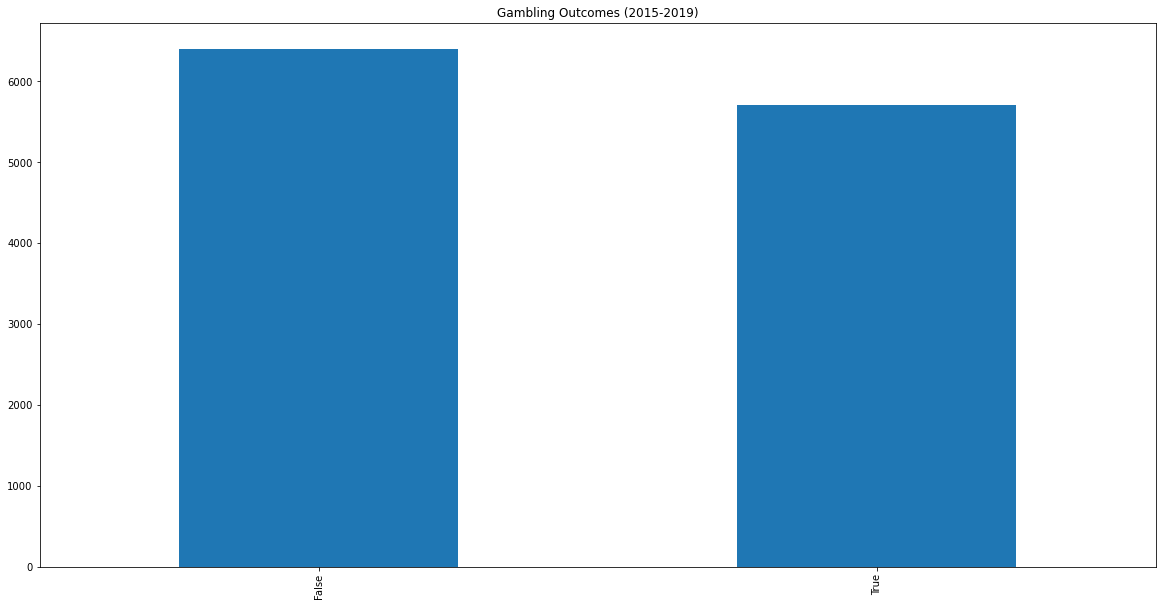

In [5]:
odds_split=game_data.OVER.value_counts()
odds_split
fig,ax=plt.subplots(figsize=(20,10))
ax.set_title('Gambling Outcomes (2015-2019)')
odds_split.plot.bar(ax=ax);

Apprears well-balanced.  False outcomes should be more likely since they include observations which neither the over nor under hit.

## Pitching Experience

In [28]:
A=game_data.Away_Pitcher.value_counts()
H=game_data.Home_Pitcher.value_counts()
Pitchers=pd.concat([A,H],axis=1).fillna(0)
Pitchers['Total_Starts']=Pitchers.Away_Pitcher+Pitchers.Home_Pitcher
Pitchers=Pitchers.reset_index(level=1)

,level_1,Away_Pitch,Home_Pitch,Total_Starts
Jose Quintana,/players/q/quintjo01.shtml,82.0,76.0,158.0
Jake Arrieta,/players/a/arrieja01.shtml,82.0,67.0,149.0
Chris Sale,/players/s/salech01.shtml,79.0,68.0,147.0
Gerrit Cole,/players/c/colege01.shtml,78.0,73.0,151.0
Max Scherzer,/players/s/scherma01.shtml,78.0,80.0,158.0
...,...,...,...,...
Drew Gagnon,/players/g/gagnodr01.shtml,0.0,1.0,1.0
Rico Garcia,/players/g/garciri01.shtml,0.0,1.0,1.0
Jose Ruiz,/players/r/ruizjo01.shtml,0.0,1.0,1.0
Jaime Schultz,/players/s/schulja02.shtml,0.0,1.0,1.0


In [32]:
def get_experience(game):
    away_exp=Pitchers.loc[game.Away_Pitcher[0]].Total_Starts
    home_exp=Pitchers.loc[game.Home_Pitcher[0]].Total_Starts
    return away_exp+home_exp
game_data['pitcher_observations']=game_data.apply(get_experience,axis=1)

In [34]:
game_data.pitcher_observations.value_counts()

173.0    103
171.0     94
158.0     85
169.0     83
184.0     81
        ... 
9.0        2
11.0       2
12.0       2
8.0        1
312.0      1
Name: pitcher_observations, Length: 311, dtype: int64

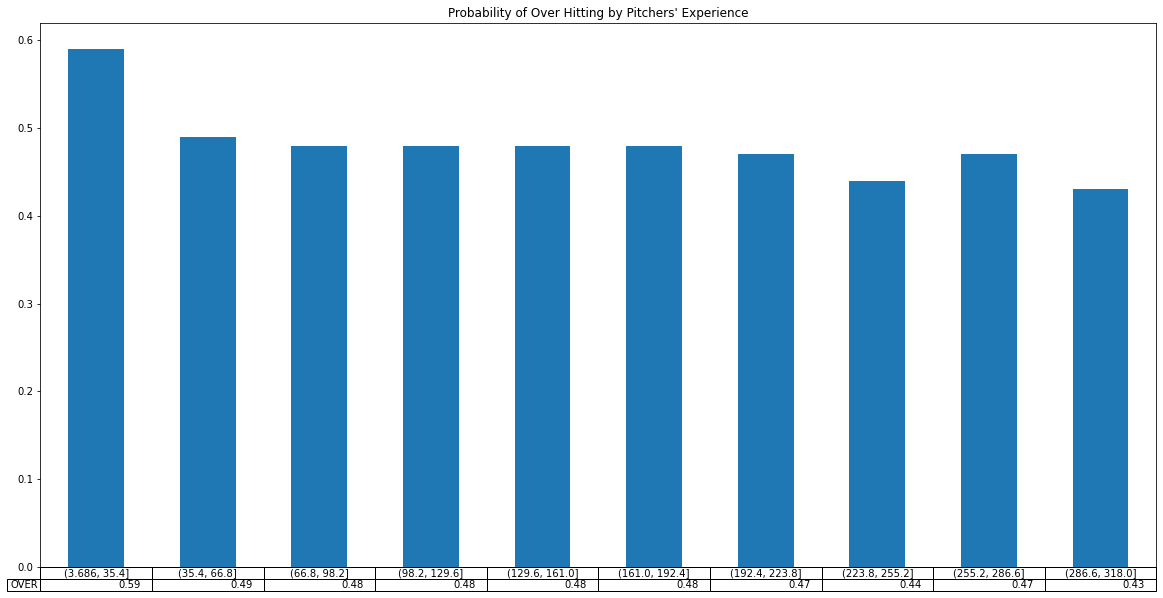

In [76]:
fig,ax=plt.subplots(figsize=(20,10))
ax.set_title('Probability of Over Hitting by Pitchers\' Experience')

buckets=pd.cut(game_data.pitcher_observations,10)
avgs=game_data.OVER.groupby(buckets).mean()
cell_text=[str(a) for a in avgs]
ax.xaxis.set_visible(False)

avgs.apply(lambda x:round(x,2)).plot.bar(ax=ax,table=True);

Ultiamtely, it does appear that when the starting pitchers are less experienced, the OVER has a higher chance of hitting.  This makes sense considering the odds-maker would have fewer observations to base their expectations.  It also might be explained by the fact that less-experienced pitchers are more likely to give up more runs.

## Value of O/U Line

In [16]:
by_line=game_data.groupby(['CloseOU']).OVER.agg(['sum','count','mean'])
by_line

,sum,count,mean
CloseOU,,,
5.0,0,1,0.000000
5.5,4,8,0.500000
6.0,29,69,0.420290
6.5,154,275,0.560000
7.0,443,999,0.443443
7.5,883,1661,0.531607
8.0,847,1795,0.471866
8.5,1118,2353,0.475138
9.0,955,2198,0.434486


There is no evidence that the OVER hitting has any relationship to where the line was set.

## By Team &/Or By Time

In [ ]:
by_ATeam=game_data.groupby(['Away_Team']).OVER.agg(['sum','count','mean'])
by_HTeam=game_data.groupby(['Home_Team']).OVER.agg(['sum','count','mean'])
by_Team=by_ATeam+by_HTeam
by_Team['mean']=by_Team['sum']/by_Team['count']
by_Team

There is no evidence that the oddsmakers have any difficulty setting the line for a particular team over the entire period of observation.

In [8]:
annual_splits=game_data.groupby(['year']).OVER.agg(['sum','count','mean'])
monthly_splits=game_data.groupby(['month']).OVER.agg(['sum','count','mean'])

There is no evidence that oddsmakers struggle with setting the line in any given month.  This is somewhat surprising as one might expect that earlier in the season, it is harder to make proper estimations.

Similarly, there is no evidence that oddsmakers struggled to set proper lines in any particular year. 

In [10]:
Hteams_years=game_data.pivot_table(['OVER'],index=['Home_Team'],columns=['year'],aggfunc='mean')
Ateams_years=game_data.pivot_table(['OVER'],index=['Away_Team'],columns=['year'],aggfunc='mean')
teams_years=(Ateams_years+Hteams_years)/2
teams_years.index.name='Team'
teams_years

OVER                                        
year      2015      2016      2017      2018      2019
Team                                                  
ARI   0.500000  0.534568  0.453781  0.456790  0.450617
ATL   0.487654  0.505626  0.493827  0.469136  0.469136
BAL   0.478870  0.403164  0.500000  0.456790  0.493827
BOS   0.506173  0.475309  0.444444  0.481481  0.565201
CHC   0.425926  0.450617  0.456790  0.432099  0.475309
CHW   0.471605  0.477855  0.450617  0.475309  0.450000
CIN   0.493750  0.537037  0.524691  0.487654  0.376543
CLE   0.478858  0.492655  0.388889  0.469136  0.438272
COL   0.512346  0.444444  0.382716  0.411021  0.481481
DET   0.528241  0.490585  0.530864  0.438272  0.422299
HOU   0.438272  0.456790  0.500000  0.438272  0.434568
KCR   0.459645  0.462963  0.462963  0.438272  0.502778
LAA   0.462963  0.425926  0.419753  0.432099  0.475309
LAD   0.477778  0.432099  0.475309  0.466501  0.475309
MIA   0.481481  0.490201  0.515670  0.491358  0.462963
MIL   0.487654  0.462963  0.414292  0.484568  0.425926
MIN   0.444444  0.580247  0.434645  0.493827  0.487654
NYM   0.527623  0.456556  0.558719  0.441204  0.465741
NYY   0.475309  0.434877  0.500000  0.481250  0.517503
OAK   0.543210  0.444444  0.518519  0.493827  0.438272
PHI   0.524691  0.471605  0.434954  0.450617  0.453472
PIT   0.456790  0.543210  0.388889  0.440818  0.567901
SDP   0.586420  0.496605  0.490664  0.481481  0.447377
SEA   0.487654  0.481481  0.447145  0.478472  0.515201
SFG   0.475309  0.459259  0.456790  0.432099  0.487654
STL   0.416590  0.512500  0.512346  0.462963  0.410031
TBR   0.470560  0.487654  0.475309  0.450617  0.484414
TEX   0.438272  0.500000  0.456790  0.466435  0.462963
TOR   0.481481  0.382716  0.456790  0.497454  0.462963
WSN   0.521991  0.471914  0.425926  0.472608  0.462963

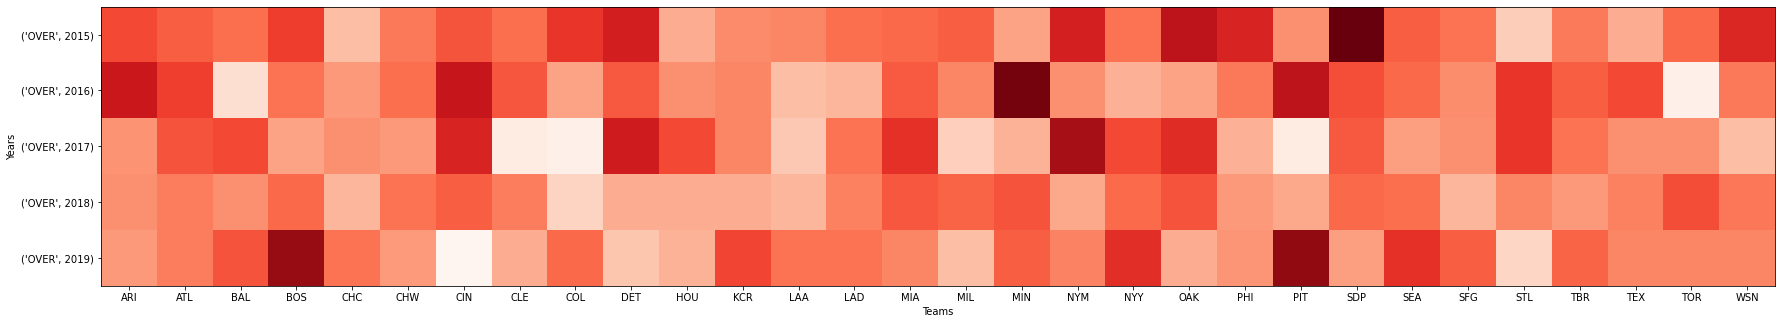

In [11]:
fig,ax=plt.subplots(figsize=(30,30))
indX=np.arange(teams_years.shape[0])
indY=np.arange(teams_years.shape[1])
im=ax.imshow(teams_years.transpose(),cmap='Reds')
ax.set_xlabel('Teams');
ax.set_ylabel('Years');
ax.set_xticks(indX);
ax.set_yticks(indY);
ax.set_yticklabels(teams_years.columns);
ax.set_xticklabels(teams_years.index);

In [124]:
away_monthly_splits=game_data.groupby(['Away_Team','year','month'])['OVER'].mean()
home_monthly_splits=game_data.groupby(['Home_Team','year','month'])['OVER'].mean()
away_monthly_splits.index.names=['Team','year','month']
home_monthly_splits.index.names=['Team','year','month']
monthly_team_splits=(away_monthly_splits+home_monthly_splits)/2
monthly_pivot=monthly_team_splits.unstack().unstack().swaplevel('month','year',axis=1)
monthly_pivot=monthly_pivot.sort_index(axis=1,level=0).dropna(axis=1)

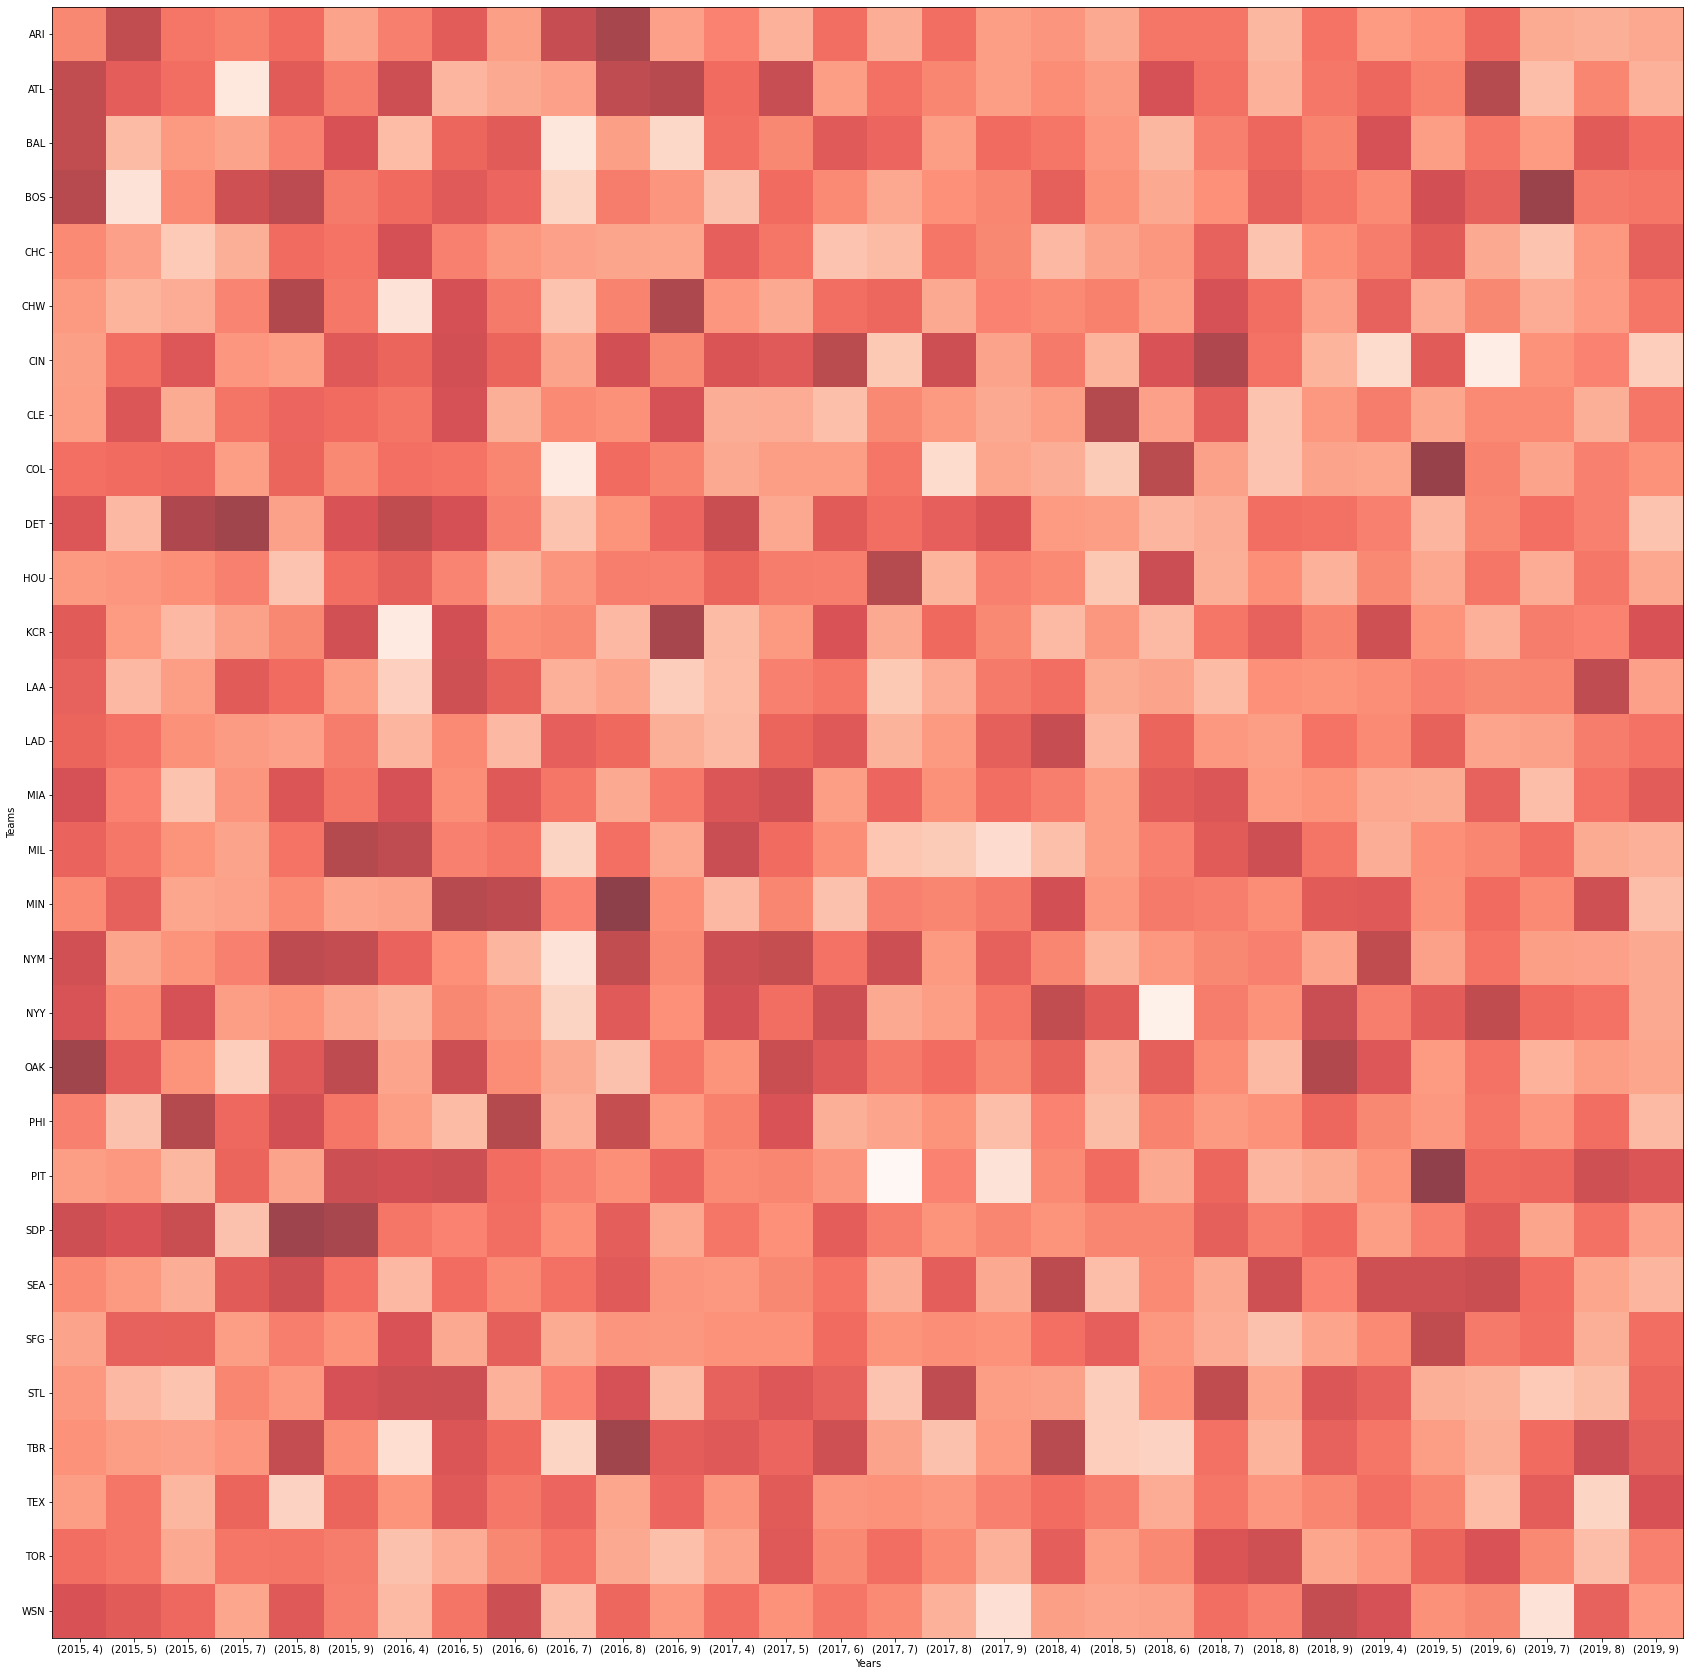

In [130]:
fig,ax=plt.subplots(figsize=(30,30))
indX=np.arange(monthly_pivot.shape[1])
indY=np.arange(monthly_pivot.shape[0])
im=ax.imshow(monthly_pivot,cmap='Reds',alpha=0.75)
ax.set_ylabel('Teams');
ax.set_xlabel('Years');
ax.set_xticks(indX);
ax.set_yticks(indY);
ax.set_xticklabels(monthly_pivot.columns);
ax.set_yticklabels(monthly_pivot.index);

The heatmaps above suggest that over a single year or given month (or other short-term period) that oddsmakers struggle to properly set the line for a specific team.

# Modeling

## Initial Setup

In [2]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [4]:
stats_years=pd.read_pickle('../Merged DFs/team_annual_statistics.pkl')
game_data=pd.read_pickle('../Merged DFs/Games_AllData.pkl')

## Merge Statistics w/ Game Info (Including Target Variable)

In [6]:
Away_Stats=game_data.apply(lambda r:stats_years.loc[(r.Away_Team,str(r.year-1)),:],axis=1)
Home_Stats=game_data.apply(lambda r:stats_years.loc[(r.Home_Team,str(r.year-1)),:],axis=1)

In [7]:
stats=pd.merge(Away_Stats,Home_Stats,left_index=True,right_index=True,suffixes=['_A','_H'])

In [8]:
stats

,#Bat_A,BatAge_A,PA_A,AB_A,R_A,H_A,2B_A,3B_A,HR_A,RBI_A,...,SVSit_H,IS%_H,aLI_H,IPmult_H,0DR_H,DefEff_H,CG_H,Fld%_H,Rtot/yr_H,Rgood_H
0,53.0,29.8,37.574074,34.030864,4.179012,8.654321,1.580247,0.197531,1.086420,3.975309,...,0.987654,0.35,0.982,0.987654,0.716049,0.717,1116.0,0.985,4.0,0.0
1,53.0,29.8,37.574074,34.030864,4.179012,8.654321,1.580247,0.197531,1.086420,3.975309,...,0.987654,0.35,0.982,0.987654,0.716049,0.717,1116.0,0.985,4.0,0.0
2,48.0,27.8,37.444444,33.623457,4.271605,8.524691,1.790123,0.234568,0.969136,4.104938,...,0.858025,0.26,0.903,1.154321,0.635802,0.685,1084.0,0.984,-3.0,1.0
3,51.0,26.5,37.475309,34.092593,4.049383,8.222222,1.598765,0.246914,1.123457,3.944444,...,0.703704,0.37,0.991,0.820988,0.462963,0.680,1234.0,0.987,-2.0,-4.0
4,49.0,29.2,38.006173,33.703704,4.277778,7.919753,1.598765,0.308642,1.086420,4.061728,...,1.061728,0.24,1.009,0.783951,0.709877,0.698,910.0,0.983,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12111,45.0,29.0,36.901235,33.302469,3.672840,7.913580,1.567901,0.123457,0.808642,3.469136,...,1.012346,0.36,1.078,0.493827,0.561728,0.694,1043.0,0.983,3.0,-4.0
12112,45.0,29.6,38.549383,34.228395,4.500000,8.358025,1.561728,0.203704,0.901235,4.234568,...,0.956790,0.27,1.002,0.783951,0.537037,0.712,1136.0,0.986,3.0,-5.0
12113,49.0,27.3,38.049383,34.641975,4.660494,9.574074,1.895062,0.253086,1.148148,4.450617,...,0.925926,0.30,0.969,0.672840,0.629630,0.703,1054.0,0.984,4.0,-1.0
12114,55.0,29.2,38.067901,34.253086,4.462963,8.858025,1.740741,0.148148,1.092593,4.259259,...,0.839506,0.26,1.022,0.759259,0.691358,0.700,1108.0,0.985,-2.0,-6.0


In [9]:
dataset=pd.merge(game_data[['OVER','month','CloseOU']],stats,left_index=True,right_index=True)

## Prep Data for Training

In [13]:
X=dataset.drop('OVER',axis=1)
y=dataset.OVER
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1988)

In [14]:
X_train.index

Int64Index([ 6349,  5672,  4856, 10535,  8360,  6068,   351,  7969,  6044,
             4539,
            ...
             8107, 11891,   869, 12032, 11069,   936,  6961,  6709,  3048,
            10093],
           dtype='int64', length=9087)

In [15]:
scaler=StandardScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train),columns=X_train.columns,index=X_train.index)
X_test=pd.DataFrame(scaler.transform(X_test),columns=X_test.columns,index=X_test.index)

,month,CloseOU,#Bat_A,BatAge_A,PA_A,AB_A,R_A,H_A,2B_A,3B_A,...,SVSit_H,IS%_H,aLI_H,IPmult_H,0DR_H,DefEff_H,CG_H,Fld%_H,Rtot/yr_H,Rgood_H
6349,0.271969,-0.066053,-0.103468,-1.343652,1.006523,1.488001,0.178522,0.211159,0.493518,0.683861,...,1.392998,-0.489628,-0.588055,0.107729,1.978271,0.865845,-0.819928,0.788177,0.647135,-0.721767
5672,-0.301704,0.369524,-1.358480,0.448780,0.533318,-0.416749,0.763546,0.121232,-0.311212,0.039219,...,-0.616087,-0.489628,-0.658443,1.179050,-0.436337,-0.399009,0.287078,-0.117738,-1.680332,-0.914585
4856,-1.449049,-0.066053,0.942376,2.052535,0.812939,0.967171,0.834890,0.765707,-0.995233,-1.250066,...,0.812596,0.261977,-0.024950,-0.392220,-0.898708,-0.760396,-0.070021,1.241134,-0.350351,-1.300221
10535,-0.301704,-1.372784,-0.730974,0.165765,-0.703467,-1.369124,-1.291172,-0.358378,-0.029556,-0.820305,...,0.321486,-1.241232,0.467767,-1.070723,0.180159,0.052725,-0.569959,-0.570695,0.314639,0.049504
8360,-0.301704,-0.066053,-0.312637,0.543119,0.017095,0.699315,-0.192469,1.365219,0.493518,1.113623,...,0.946535,-2.243371,2.086694,-1.284988,1.002153,-0.941089,-1.998355,-1.476610,-0.350351,-0.914585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,-0.301704,-0.937207,0.524038,-0.211589,2.221799,0.803481,1.348570,-0.013658,0.815411,0.468980,...,0.142901,0.261977,1.148186,-0.713617,-0.230838,0.233418,0.090674,-0.117738,-0.017856,1.206411
6961,1.419314,0.805101,1.779050,-0.211589,-1.617613,-1.473290,-0.335158,-1.797207,-0.753814,-0.283103,...,-0.750026,1.765185,0.444304,-0.392220,1.310401,-2.205943,-0.016456,-0.570695,-1.015342,2.170500
6709,0.845642,1.240678,0.942376,2.052535,0.812939,0.967171,0.834890,0.765707,-0.995233,-1.250066,...,-0.839319,0.261977,0.092364,0.357704,1.259026,0.233418,1.036986,-0.570695,0.314639,-1.493039
3048,-0.875376,-0.501630,0.524038,-0.400267,0.425772,-1.636980,0.863428,-0.718085,1.459195,-0.927745,...,0.678657,1.765185,-0.376891,-0.142245,0.796655,0.143071,1.054841,1.694091,-0.017856,1.592047


## Train Models

In [17]:
log_model=LogisticRegression(random_state=1988,max_iter=1000)
log_model.fit(X_train,y_train)
log_model.score(X_train,y_train)

0.5569494882799604

In [18]:
log_results=ModelWithCV(log_model,'simple_log',X_train,y_train)

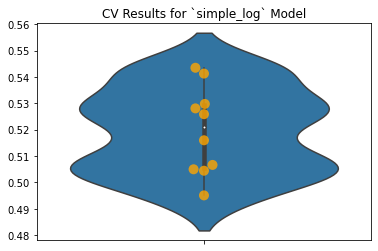

In [19]:
log_results.cv_results
fig,ax=plt.subplots()
ax=log_results.plot_cv(ax)
plt.plot();

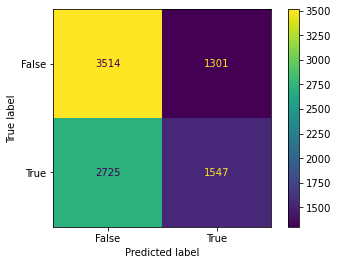

In [20]:
plot_confusion_matrix(log_model,X_train,y_train)

In [21]:
print(classification_report(y_test,log_model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.53      0.69      0.60      1589
        True       0.49      0.33      0.39      1440

    accuracy                           0.52      3029
   macro avg       0.51      0.51      0.50      3029
weighted avg       0.51      0.52      0.50      3029



In [22]:
param_grid={
    'max_iter':[500,1000,2000],
    'penalty':['l1','l2','none'],
    'solver':['liblinear','lbfgs'],
}

In [23]:
grid_logistic=GridSearchCV(LogisticRegression(random_state=1988),param_grid,cv=5,scoring='accuracy',verbose=1,n_jobs=-1)

In [24]:
grid_logistic.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.4min finished
/Users/george/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=1988), n_jobs=-1,
             param_grid={'max_iter': [500, 1000, 2000],
                         'penalty': ['l1', 'l2', 'none'],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='accuracy', verbose=1)

In [39]:
print(grid_logistic.best_score_)
print(grid_logistic.best_params_)
print(grid_logistic.best_estimator_)
dict(zip(X_train.columns.values,grid_logistic.best_estimator_.coef_[0]))

0.5250373413786068
{'max_iter': 500, 'penalty': 'none', 'solver': 'lbfgs'}
LogisticRegression(max_iter=500, penalty='none', random_state=1988)


{'month': 0.007333604126954191,
 'CloseOU': -0.10081052422696882,
 '#Bat_A': 0.052575876884372645,
 'BatAge_A': 0.039539227991777795,
 'PA_A': -0.8173087217826625,
 'AB_A': 0.3873455138284138,
 'R_A': 0.4143055363386354,
 'H_A': 0.744206138080802,
 '2B_A': 0.08807066600732492,
 '3B_A': 0.0632547940173792,
 'HR_A': -0.14050440047659338,
 'RBI_A': -0.5647006406121532,
 'SO_A': 0.10202408407358583,
 'BA_A': 0.13273448350191253,
 'OPS+_A': 0.7215300735416027,
 'GDP_A': -0.011246040262303266,
 'LO_A': 0.03744295513849785,
 'Steal Attempts_A': -0.06126355715542191,
 'Sacs_A': 0.12693793069937373,
 'Free_Bases_A': 0.7035252648491217,
 'AIR_A': -0.32407696975584965,
 'BAbip_A': -0.5313907242718434,
 'OWn%_A': -0.032953475916688756,
 'BtRuns_A': -0.8587073283390328,
 'PwrSpd_A': 0.023310782022031584,
 '#P_A': -0.030125903603160125,
 'PAge_A': -0.013679832506537965,
 'RA/G_A': 0.6524414954501373,
 'CG_A': 0.039599942974421695,
 'tSho_A': 0.015077257941635423,
 'cSho_A': 0.011637748780670793,
 'I

In [40]:
print(classification_report(y_test,grid_logistic.best_estimator_.predict(X_test)))


              precision    recall  f1-score   support

       False       0.54      0.68      0.60      1589
        True       0.50      0.35      0.41      1440

    accuracy                           0.52      3029
   macro avg       0.52      0.52      0.51      3029
weighted avg       0.52      0.52      0.51      3029



In [48]:
param_grid = { 
    'n_estimators': [300,400,600],
    'min_samples_leaf':[25,50],
    'max_leaf_nodes':range(50,75,5),
    'max_features' :['auto', 5,6]
}

In [52]:
grid_forest=GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

In [53]:
grid_forest.fit(X_train,y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 12.5min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['auto', 5, 6],
                         'max_leaf_nodes': range(50, 75, 5),
                         'min_samples_leaf': [25, 50],
                         'n_estimators': [300, 400, 600]},
             scoring='accuracy', verbose=1)

In [54]:
print(grid_forest.best_score_)
print(grid_forest.best_params_)
print(grid_forest.best_estimator_)
print(grid_forest.best_estimator_.feature_importances_)

0.526133939756111
{'max_features': 6, 'max_leaf_nodes': 50, 'min_samples_leaf': 25, 'n_estimators': 400}
RandomForestClassifier(max_features=6, max_leaf_nodes=50, min_samples_leaf=25,
                       n_estimators=400)
[0.00756672 0.01454236 0.00574154 0.0091307  0.01031195 0.01159294
 0.00960093 0.01061944 0.01043863 0.0085069  0.00958731 0.00923919
 0.01048592 0.00727547 0.00927778 0.00760152 0.00747388 0.01146929
 0.00958252 0.01065014 0.01025514 0.00839192 0.00926805 0.01114481
 0.01267264 0.00516348 0.00735227 0.00989058 0.00383252 0.00729127
 0.00240021 0.00928163 0.01190697 0.00976547 0.0117501  0.00864259
 0.00247708 0.00977613 0.00923214 0.00854973 0.00808384 0.00741707
 0.00738554 0.00377334 0.00238807 0.00871819 0.00457792 0.00400826
 0.00697215 0.00683383 0.00856745 0.00576596 0.01443625 0.00845498
 0.00844538 0.00947654 0.01005553 0.00504301 0.00651761 0.00575918
 0.0071017  0.00843527 0.01067142 0.0111561  0.00874656 0.01000872
 0.01073847 0.00800385 0.00891729 0.00

In [55]:
dict(zip(X_test.columns,grid_forest.best_estimator_.feature_importances_))

{'month': 0.007566719045765439,
 'CloseOU': 0.014542356020649062,
 '#Bat_A': 0.005741537607809422,
 'BatAge_A': 0.00913069799121012,
 'PA_A': 0.010311950081696638,
 'AB_A': 0.011592942480308795,
 'R_A': 0.009600934927102673,
 'H_A': 0.010619444488916455,
 '2B_A': 0.010438627198499644,
 '3B_A': 0.008506899234760482,
 'HR_A': 0.009587310872836773,
 'RBI_A': 0.009239188004930338,
 'SO_A': 0.011906974926768944,
 'BA_A': 0.007275472284641796,
 'OPS+_A': 0.009277781243860968,
 'GDP_A': 0.007601524816821847,
 'LO_A': 0.007473882460614798,
 'Steal Attempts_A': 0.011469294425019136,
 'Sacs_A': 0.009582519890319871,
 'Free_Bases_A': 0.01065014302743205,
 'AIR_A': 0.010255140853422863,
 'BAbip_A': 0.008391921057525837,
 'OWn%_A': 0.009268053456683484,
 'BtRuns_A': 0.01114481415671511,
 'PwrSpd_A': 0.012672636633587246,
 '#P_A': 0.005163478309232393,
 'PAge_A': 0.007352265597553083,
 'RA/G_A': 0.009890579136414992,
 'CG_A': 0.010055531257018444,
 'tSho_A': 0.0072912664967276775,
 'cSho_A': 0.00240

In [56]:
print(classification_report(y_test,grid_forest.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

       False       0.53      0.78      0.63      1589
        True       0.50      0.25      0.33      1440

    accuracy                           0.53      3029
   macro avg       0.52      0.51      0.48      3029
weighted avg       0.52      0.53      0.49      3029



In [64]:
param_grid = { 
    'n_estimators': [500,700,800],
    'min_samples_leaf':[75,80,90],
    'max_leaf_nodes':range(75,100,5),
    'max_features' :['auto', 5,6]
}

In [65]:
grid_forest=GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

In [66]:
grid_forest.fit(X_train,y_train)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed: 26.1min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['auto', 5, 6],
                         'max_leaf_nodes': range(75, 100, 5),
                         'min_samples_leaf': [75, 80, 90],
                         'n_estimators': [500, 700, 800]},
             scoring='accuracy', verbose=1)

In [67]:
print(grid_forest.best_score_)
print(grid_forest.best_params_)
print(grid_forest.best_estimator_)
print(grid_forest.best_estimator_.feature_importances_)

0.525145354381338
{'max_features': 5, 'max_leaf_nodes': 85, 'min_samples_leaf': 80, 'n_estimators': 500}
RandomForestClassifier(max_features=5, max_leaf_nodes=85, min_samples_leaf=80,
                       n_estimators=500)
[0.00665742 0.01436272 0.00596487 0.0089629  0.0099644  0.00923143
 0.0099557  0.01098714 0.0109919  0.00812191 0.00892526 0.00949959
 0.0095879  0.00804547 0.00840783 0.00831624 0.0072638  0.01087872
 0.00819988 0.01125608 0.01049032 0.00832872 0.01031929 0.01102481
 0.01129679 0.00548356 0.00665009 0.01048992 0.00439676 0.00697305
 0.00262957 0.01077623 0.01263079 0.00894741 0.01222348 0.00938313
 0.00448827 0.00910689 0.0107579  0.00758573 0.00691229 0.00773959
 0.00721385 0.00397775 0.00254249 0.00853669 0.00666127 0.00448453
 0.00692863 0.00681389 0.00998135 0.00650442 0.01362982 0.00825467
 0.01179997 0.00782917 0.01027186 0.00533091 0.00716061 0.00720543
 0.00688102 0.00908441 0.00973849 0.0112147  0.0109653  0.00898638
 0.01005074 0.00794209 0.00998646 0.00

In [68]:
dict(zip(X_test.columns,grid_forest.best_estimator_.feature_importances_))

{'month': 0.0066574227338731095,
 'CloseOU': 0.01436271519384023,
 '#Bat_A': 0.005964869248325186,
 'BatAge_A': 0.008962899761999566,
 'PA_A': 0.009964397337885475,
 'AB_A': 0.009231434513862323,
 'R_A': 0.009955696722633576,
 'H_A': 0.010987143716345498,
 '2B_A': 0.010991900848071258,
 '3B_A': 0.008121908046829702,
 'HR_A': 0.008925262041885458,
 'RBI_A': 0.009499586546145739,
 'SO_A': 0.0126307905768664,
 'BA_A': 0.008045473262533348,
 'OPS+_A': 0.008407826753742598,
 'GDP_A': 0.008316238886088448,
 'LO_A': 0.007263798342735566,
 'Steal Attempts_A': 0.010878718676211402,
 'Sacs_A': 0.008199880701627993,
 'Free_Bases_A': 0.011256080035480712,
 'AIR_A': 0.010490316016236645,
 'BAbip_A': 0.008328715019244884,
 'OWn%_A': 0.010319288317293165,
 'BtRuns_A': 0.011024813405463312,
 'PwrSpd_A': 0.011296792699974524,
 '#P_A': 0.005483557698398243,
 'PAge_A': 0.006650087435938973,
 'RA/G_A': 0.01048992233475215,
 'CG_A': 0.01027185746252234,
 'tSho_A': 0.00697304764871493,
 'cSho_A': 0.00262956

In [69]:
print(classification_report(y_test,grid_forest.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

       False       0.53      0.81      0.65      1589
        True       0.52      0.22      0.31      1440

    accuracy                           0.53      3029
   macro avg       0.53      0.52      0.48      3029
weighted avg       0.53      0.53      0.48      3029

